# *Image processing of corroded pit - part 2: analysis of crystal sediments*

- By [Gianluca Iori](https://github.com/gianthk), Giulia Franceschin, Roberta Zanin, Elena Longo, 2022
- Code licence: MIT
- Narrative licence: CC-BY 
- How to cite: *Specify how you want people to cite this notebook. You can refer to a publication or a repository (e.g. link your GitHub repository to Zenodo - see [this video](https://www.youtube.com/watch?v=gp3D4mf6MHQ))*
- Created on:  22.04.2022
- Last update: 07.02.2023

---
# Aims
In this notebook we will use the `label toolkit` of the [spam](https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/spam_examples/label/plot_labelToolkit01.html) package to:

1. Label single crystal sediments within the corrosion pit
2. Analyse properties of single crystals such as their volume and sphericity
3. Study and generate plots of the orientation of single crystals
4. Measure the distance of sedimented particles from the pit corrosion front (particle age)
5. Plot the relationship between particle age and morphology

---
- The binary masks (i.e. corroded pit region, crystal sediments, etc..) used in this notebook are created in notebook [581681_punta_HR_stitch2_masks](581681_punta_HR_stitch2_masks.ipynb).

- For a complete explanation of the particle metrics analyzed in this notebook see the [`spam`](https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/spam_examples/label/plot_labelToolkit01.html) toolkit example [plot_labelToolkit01](https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/spam_examples/label/plot_labelToolkit01.html).
---
## To do
- [X] manual edit corrosion pit mask (Dragonfly)
- [X] particle orientation - distance from X (0-90 deg range)
- [X] shell mesh of crystal (get from ciclope)
- [X] particle distance from air voids

---
## Methods
<em>The binary mask of the corrosion pit is corrected manually: areas where the corrosion front has detached from the glass bulk are manually removed, since they contain large amounts of air and soil, and no evident layered structure. Single particles (crystal deposits) are labelled from the binary mask of crystal deposits within the corrosion pit region. The particles volume, sphericity, and 3D orientation are calculated using the [spam](https://ttk.gricad-pages.univ-grenoble-alpes.fr/spam/spam_examples/label/plot_labelToolkit01.html) python toolkit. Only particles with The distance of the sediments from the corrosion front is obtained interpolating a 3D distance transform of the pit corrosion front at the locations of each particle's center of mass.</em>

---

In [1]:
%%html
<style> table {float:left} </style>

|Scan parameters|   |
|:-|:-|
|Beamline|SYRMEP@Elettra|
|Beamtime|20217193_Traviglia - CERIC|
|Sample|581681_patina/581681_punta_HR_stitch2 |
|Energy| 27 keV |
|Camera| ORCA flash |
|Voxel size| 1.0 um |
|SDD | 150 mm |
|Preliminary operations|stitch of 4 scans (normalized; 2D rigid transform) |

---
# *Computational workflow*

## Configuration and imports

In [6]:
import sys
sys.path.append('./../../recon_utils')
# sys.path.append('/home/gianthk/PycharmProjects/CT2FE')

Configure working folder (change this to your local path)

In [58]:
pwd

'/home/beats/PycharmProjects/20217193-Franceschin/notebooks'

In [59]:
work_folder = "/run/media/beats/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt"
# work_folder = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt'
# work_folder = '/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt'
res_folder = "./../results"

In [9]:
import numpy as np
import dxchange
import matplotlib
import matplotlib.pyplot as plt
import meshio

from scipy import ndimage, stats # , misc
from skimage import morphology #, measure

from recon_utils import read_tiff_stack, plot_midplanes
# from pybonemorph import remove_unconnected, remove_largest

import spam.mesh
import spam.label
import spam.plotting
import spam.datasets

Matplotlib plotting configuration

In [70]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

## Load 3D data
### Load scalar dataset
For practical reasons we can load a small portion of the reconstructed dataset: slices [3890, 4645]

In [5]:
input_file = work_folder+'/slices_8bit_crop/slice_0000.tif'

Read portion of the file

In [6]:
# data_3D = read_tiff_stack(input_file, [3890, 4645])

Read whole file

In [8]:
data_3D = read_tiff_stack(input_file)

Voxelsize:

In [9]:
vs = np.ones(3)*1.0e-3 # [mm]

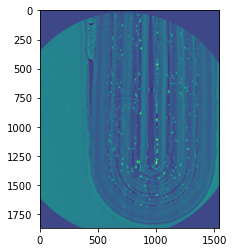

In [10]:
# Inspect slice
plt.imshow(data_3D[-1,:,:])

### Load binary mask of crystal sediments
The mask was obtained in the notebook [581681_punta_HR_stitch2_masks](581681_punta_HR_stitch2_masks.ipynb).

In [11]:
mask_file = work_folder+'/masks/crystals_crop_valid/slice_00001.tif'

In [12]:
BW_pearls = read_tiff_stack(mask_file)

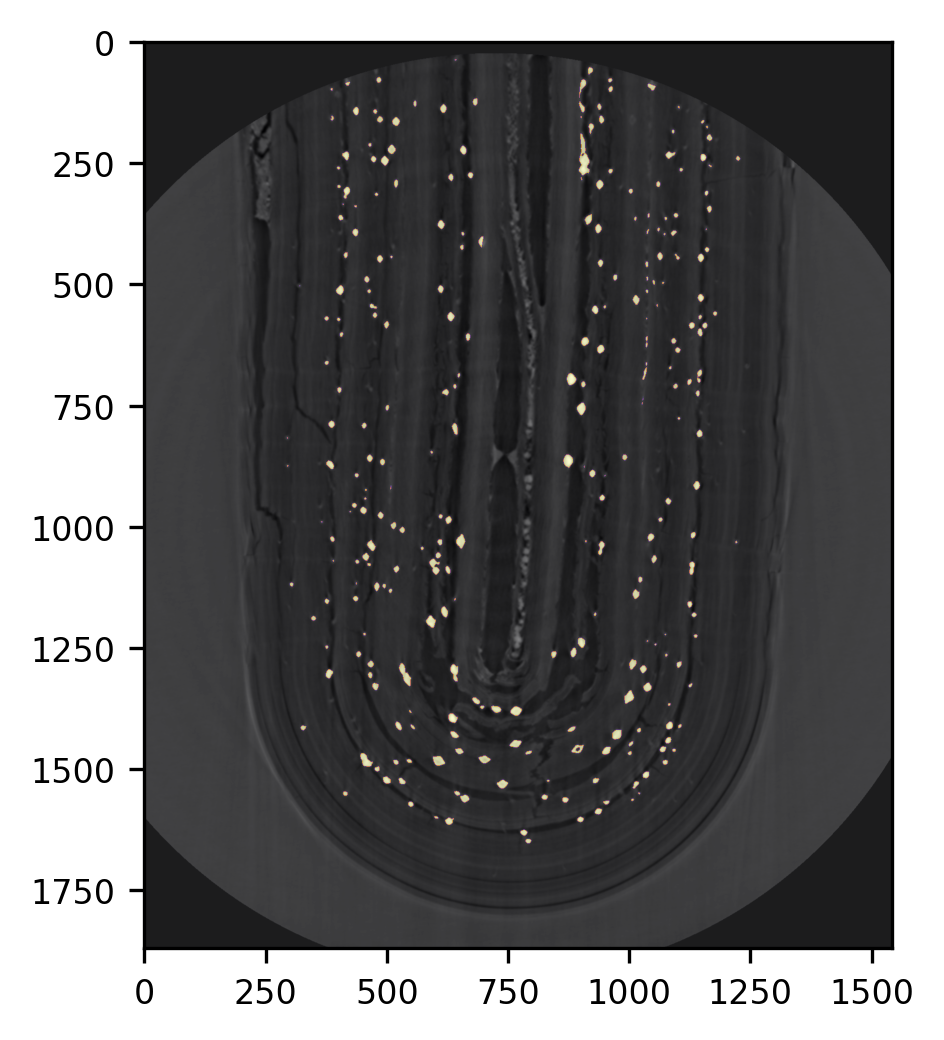

In [16]:
# Inspect slice
plt.imshow(data_3D[2050,:,:], cmap='gray')
plt.imshow(BW_pearls[2050,:,:], cmap='inferno', alpha=0.5)

## Label single particles
### With the `spam.label` toolkit
**(update: takes ages and a lot of RAM compared with `scipy.ndimage.label`)**

In [14]:
# regions_spam = spam.label.ITKwatershed.watershed(BW_pearls)
# regions = regions_spam

### With `scipy.ndimage.label`

In [17]:
regions = ndimage.label(BW_pearls)[0]

In [18]:
# print("Particles identified by spam.ITKwatershed: {}".format(regions_spam.max()))
print("Particles identified with scipy.ndimage: {}".format(regions.max()))

Particles identified with scipy.ndimage: 77573


#### Write labelled image as tiff stack

In [70]:
# dxchange.write_tiff_stack(regions, work_folder+"/masks/crystals_crop_valid_labels/slice.tiff")

Inspect the result

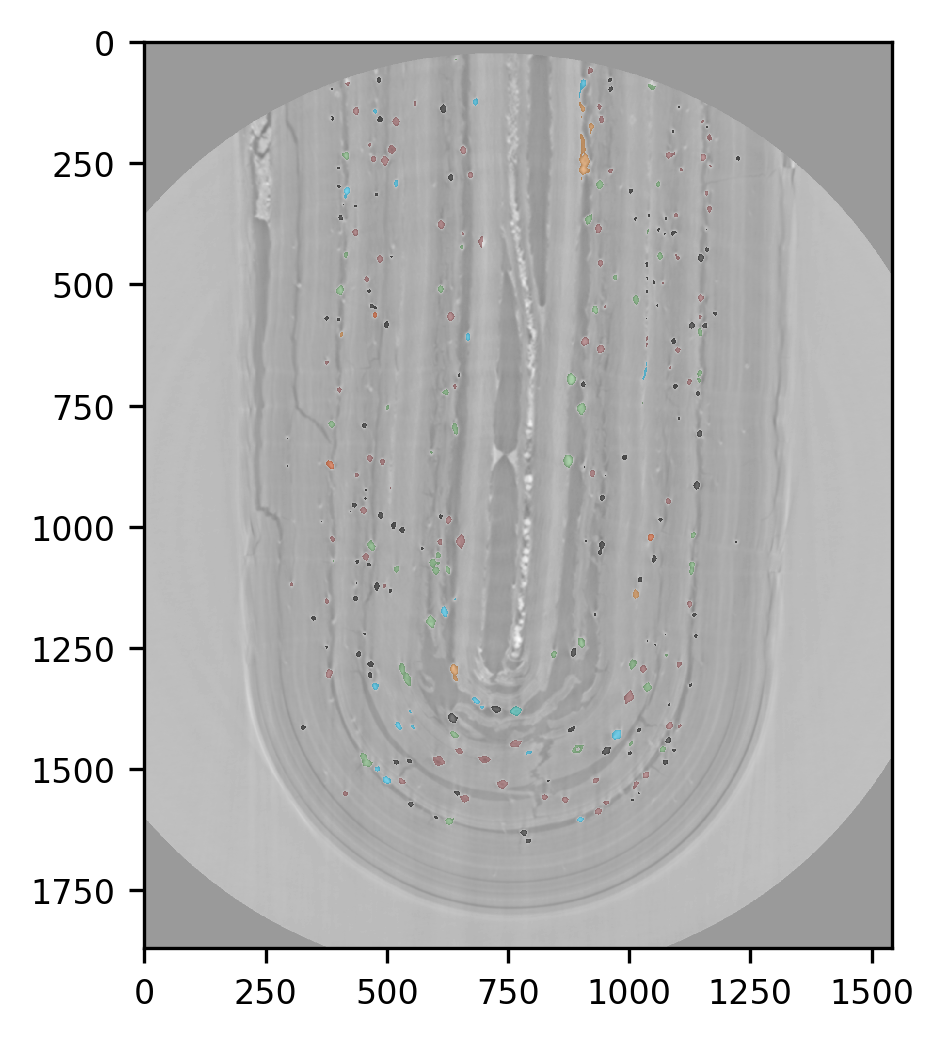

In [19]:
plt.imshow(data_3D[2050,:,:], cmap='gray', interpolation='none')
plt.imshow(regions[2050,:,:], cmap=spam.label.randomCmap, alpha=0.5, interpolation='none') # 'tab20c'

As expected, `spam.ITKwatershed` performs better than `ndimage` on clusters of particles that are not fully separated by the segmentation step. This is an issue only for corrosion layers with formation of large deposits that are excluded from particle analysis. For this reason, `ndimage`'s `label` method seems appropriate.

#### Reload labelled image
Only if you didn't run the previous section of this notebook

In [16]:
if 'regions' not in globals():
    regions = read_tiff_stack(work_folder+"/masks/crystals_crop_valid_labels/slice_00000.tiff")

## Particles volume

In [17]:
pearl_volume = spam.label.volumes(regions)

Text(0, 0.5, 'count')

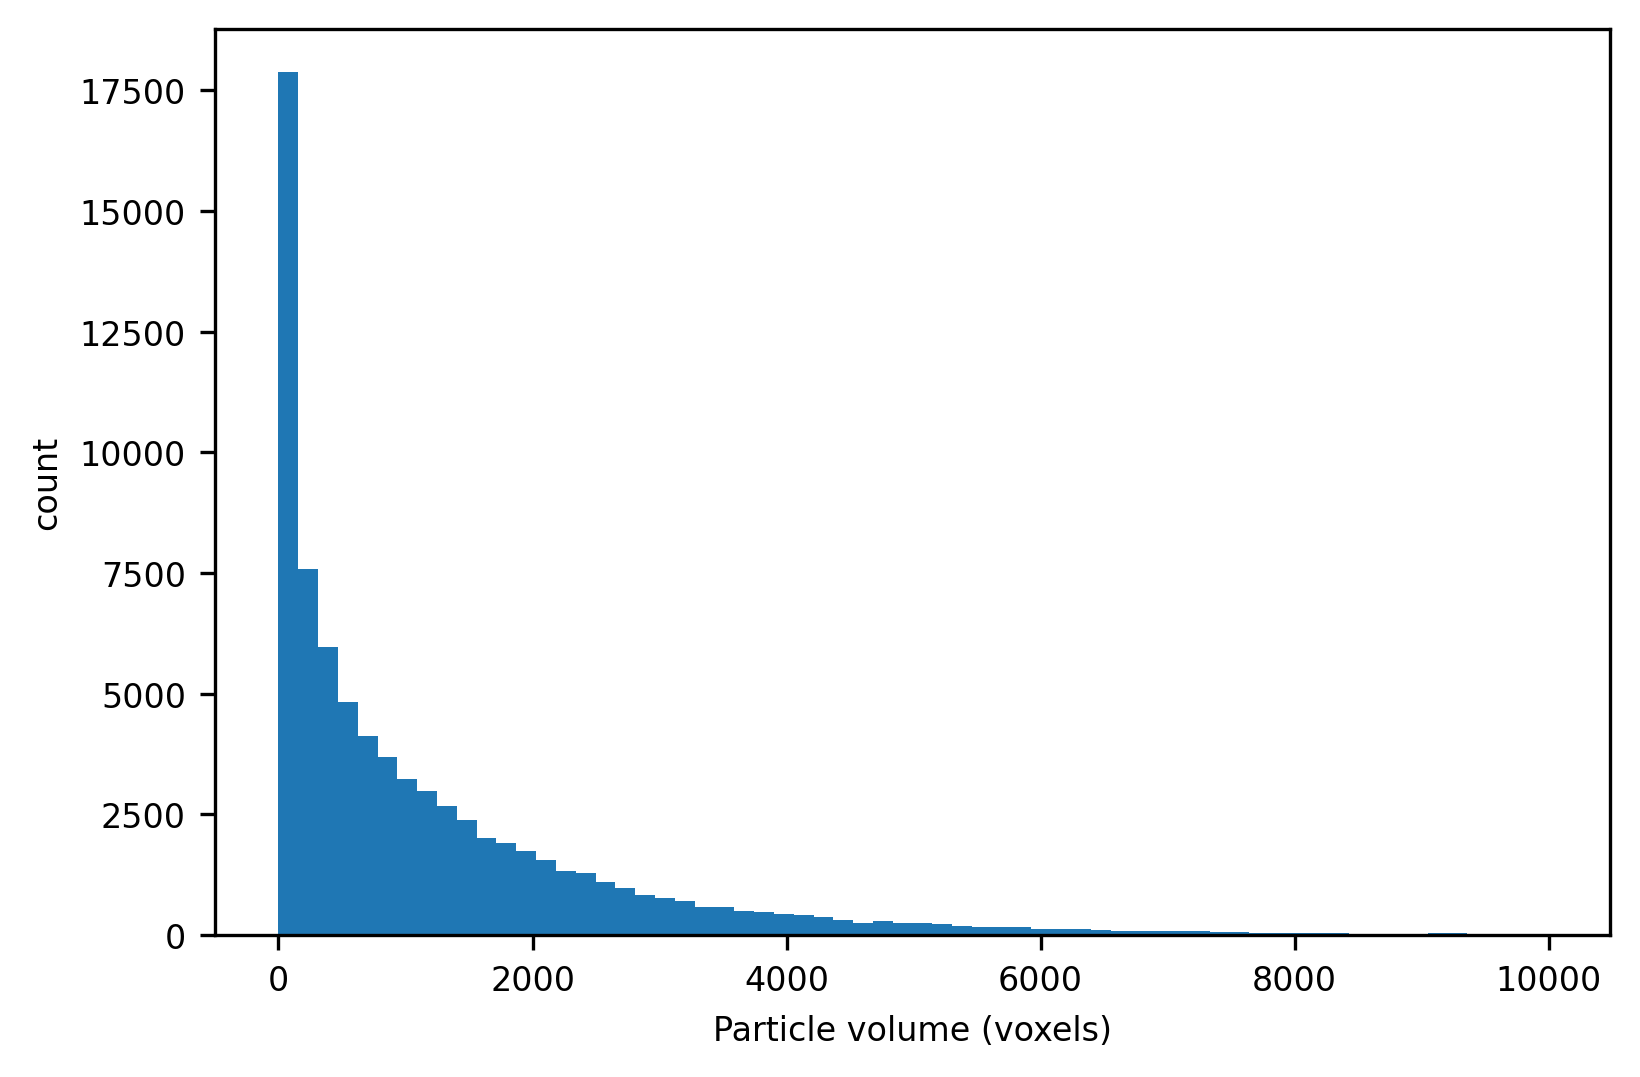

In [72]:
plt.figure()
plt.hist(pearl_volume[pearl_volume<10e3].astype('float16'), bins=64)
plt.xlabel("Particle volume (voxels)")
plt.ylabel("count")

Plot only the volume of particles larger than 100 voxels and smaller than 10'000 voxels

Text(0, 0.5, 'count')

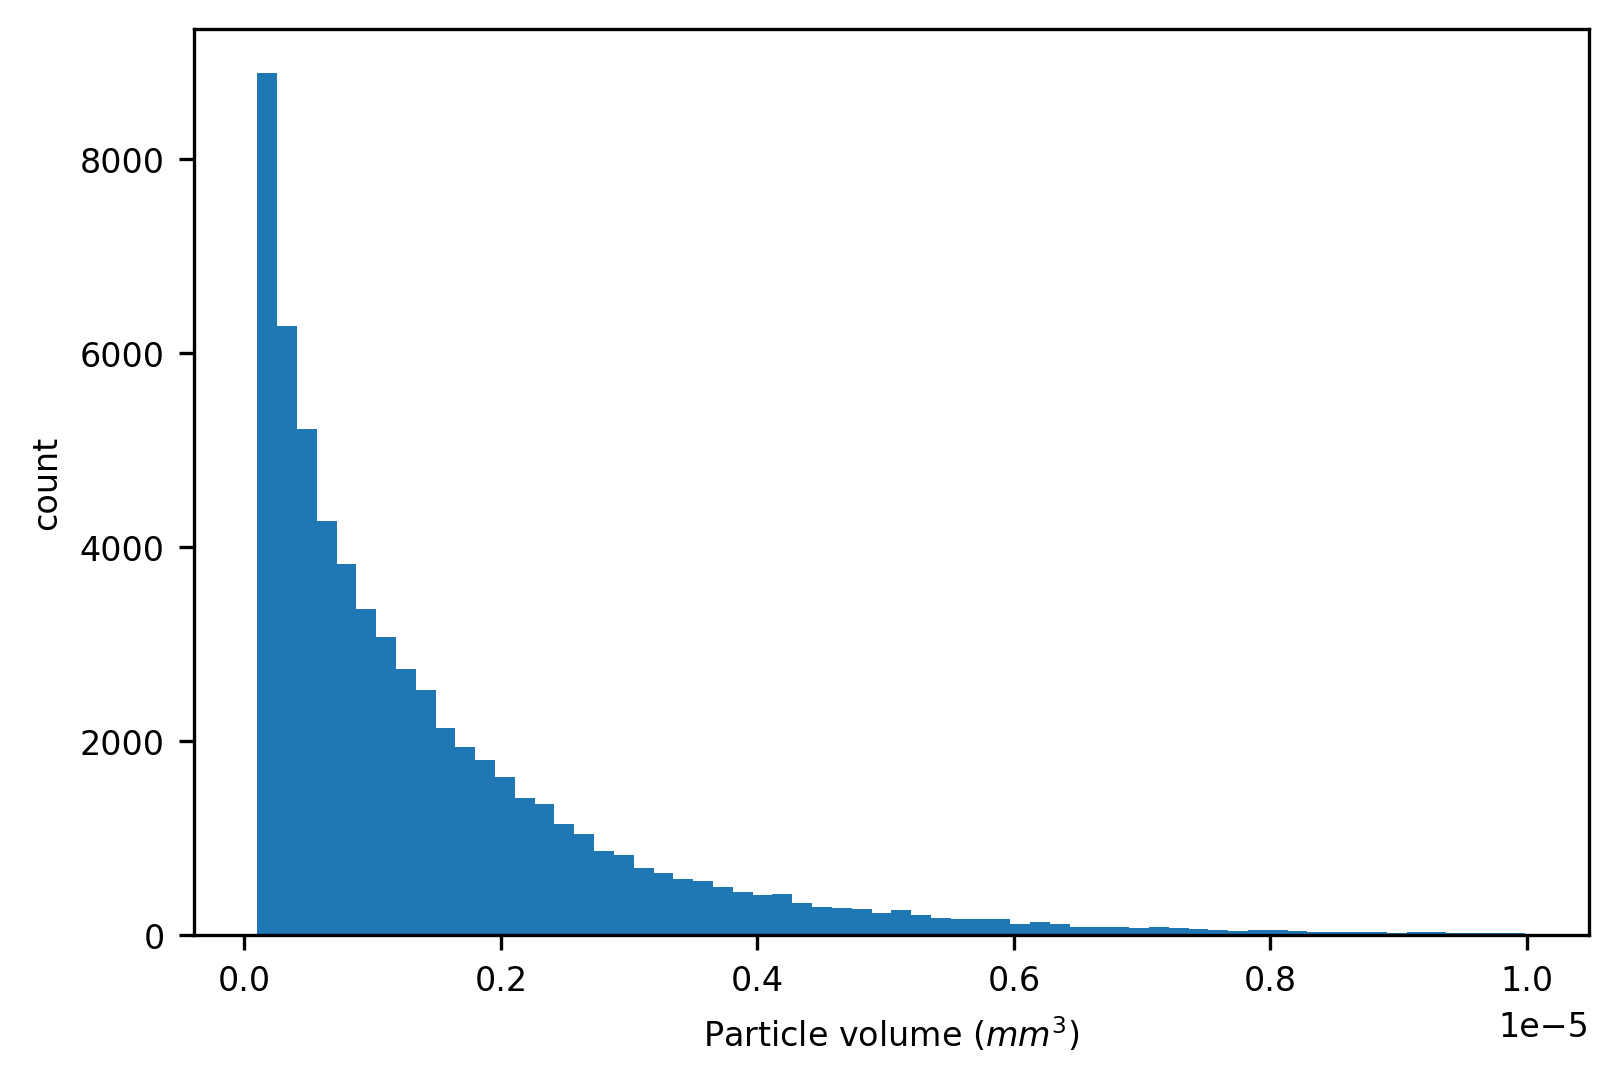

In [25]:
plt.figure()
plt.hist(pearl_volume[(pearl_volume>100) & (pearl_volume<10e3)]*1e-9, bins=64)
plt.xlabel("Particle volume ($mm^3$)")
plt.ylabel("count")

## Particles sphericity
### Compute particles bounding boxes
From the `spam.label` toolkit: "<em>Bounding boxes are simply a description of the smallest box, aligned with Z Y X directions that each label can fit inside</em>".

In [18]:
boundingBoxes = spam.label.boundingBoxes(regions)

### Compute particles centres of mass
![centers of mass](100slices_regions_CentresOfMass.png)

In [19]:
centresOfMass = spam.label.centresOfMass(regions, boundingBoxes=boundingBoxes) # Z,Y,X

### Calculate particle sphericity
From the `spam.label` toolkit: <em>"Calculates the degree of True Sphericity (psi) for all labels, as per : “Sphericity measures of sand grains” Rorato et al., Engineering Geology, 2019 and originlly proposed in: “Volume, shape, and roundness of rock particles”, Waddell, The Journal of Geology, 1932."</em>

`True Sphericity (psi) = Surface area of equivalent sphere / Actual surface area`

In [20]:
sphericity = spam.label.trueSphericity(regions, boundingBoxes=boundingBoxes, centresOfMass=centresOfMass, gaussianFilterSigma=0, minVol=1200)

#### Plot histogram of the particle sphericity
Due to computational artifacts, the calculated sphericity must be clipped to 1

Text(0, 0.5, 'count')

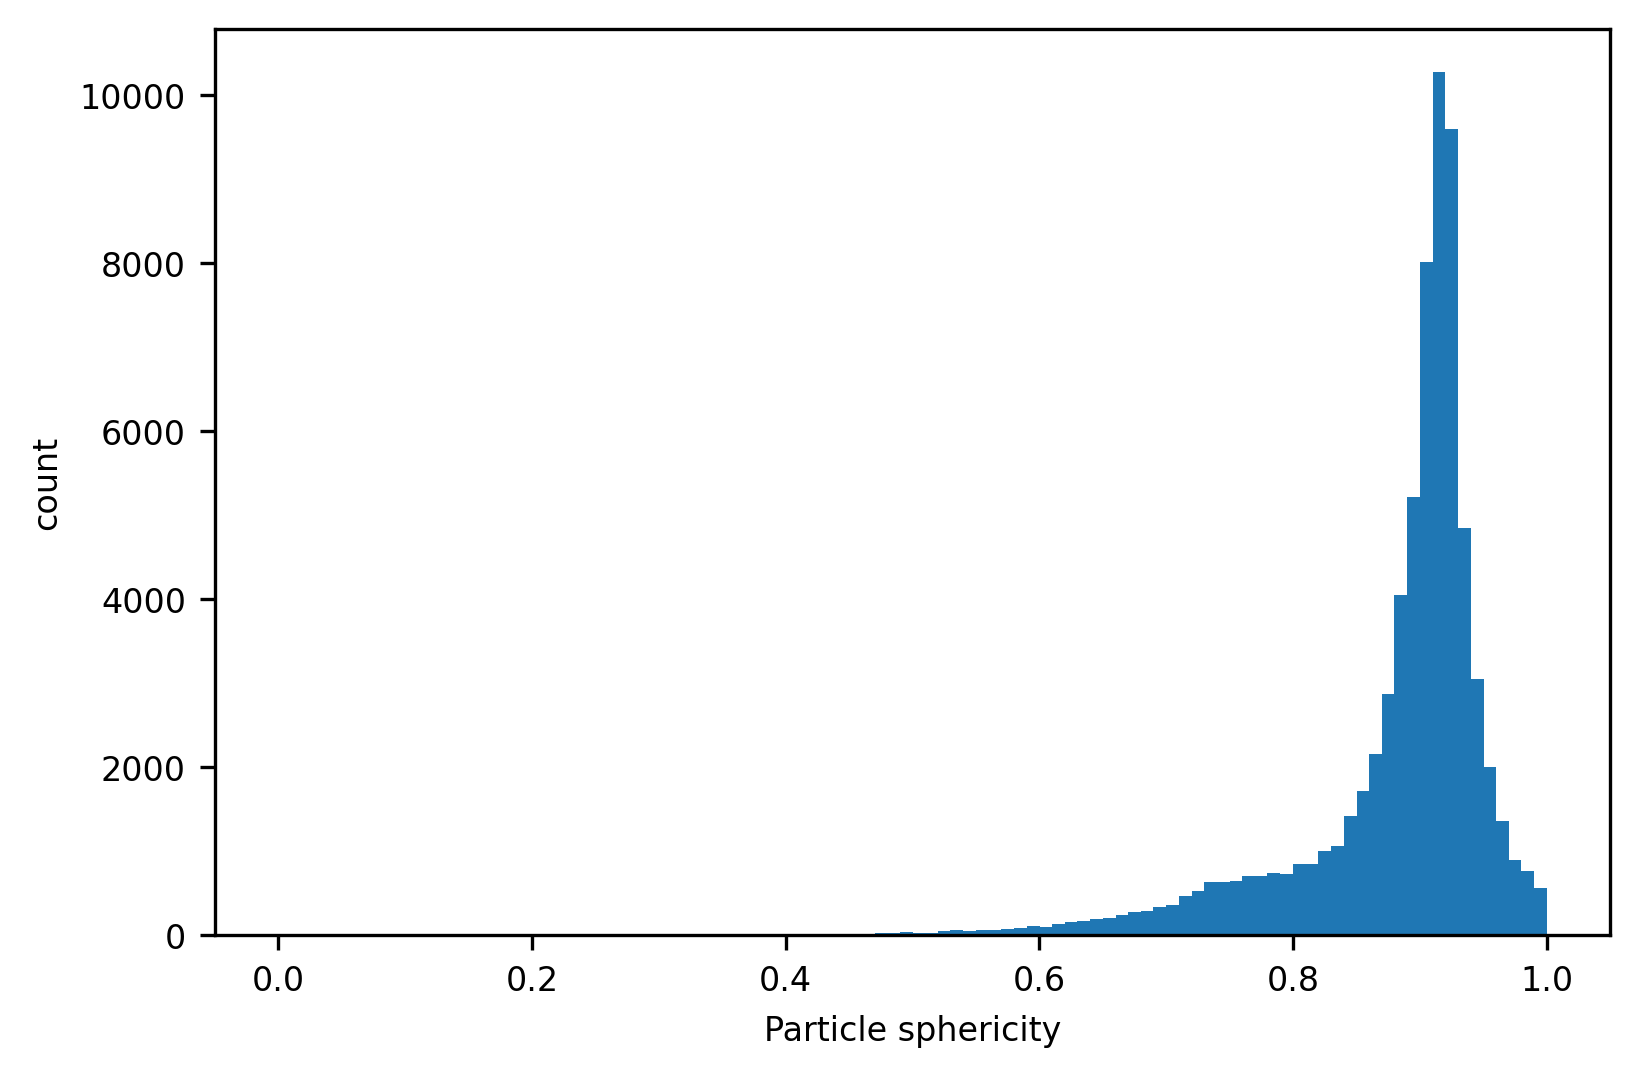

In [73]:
plt.figure()
plt.hist(sphericity[sphericity<=1].astype('float16'), bins=100)
plt.xlabel("Particle sphericity")
plt.ylabel("count")

---
Test sphericity of a known shape

In [30]:
diamond = np.pad(morphology.octahedron(12), 1)

In [31]:
sphericity_diamond = spam.label.trueSphericity(diamond, gaussianFilterSigma=0, minVol=10)

In [32]:
print("Sphericity of an octahedron:", sphericity_diamond[1])

Sphericity of an octahedron: 0.85008633


## Particles orientation
We use the `Moments of Inertia` method of the `spam.label` toolkit.

In [21]:
MOIeigenValues, MOIeigenVectors = spam.label.momentOfInertia(regions, boundingBoxes=boundingBoxes, centresOfMass=centresOfMass)

Plot of the particle orientation: display the 3D orientation of the major axes of each particle.

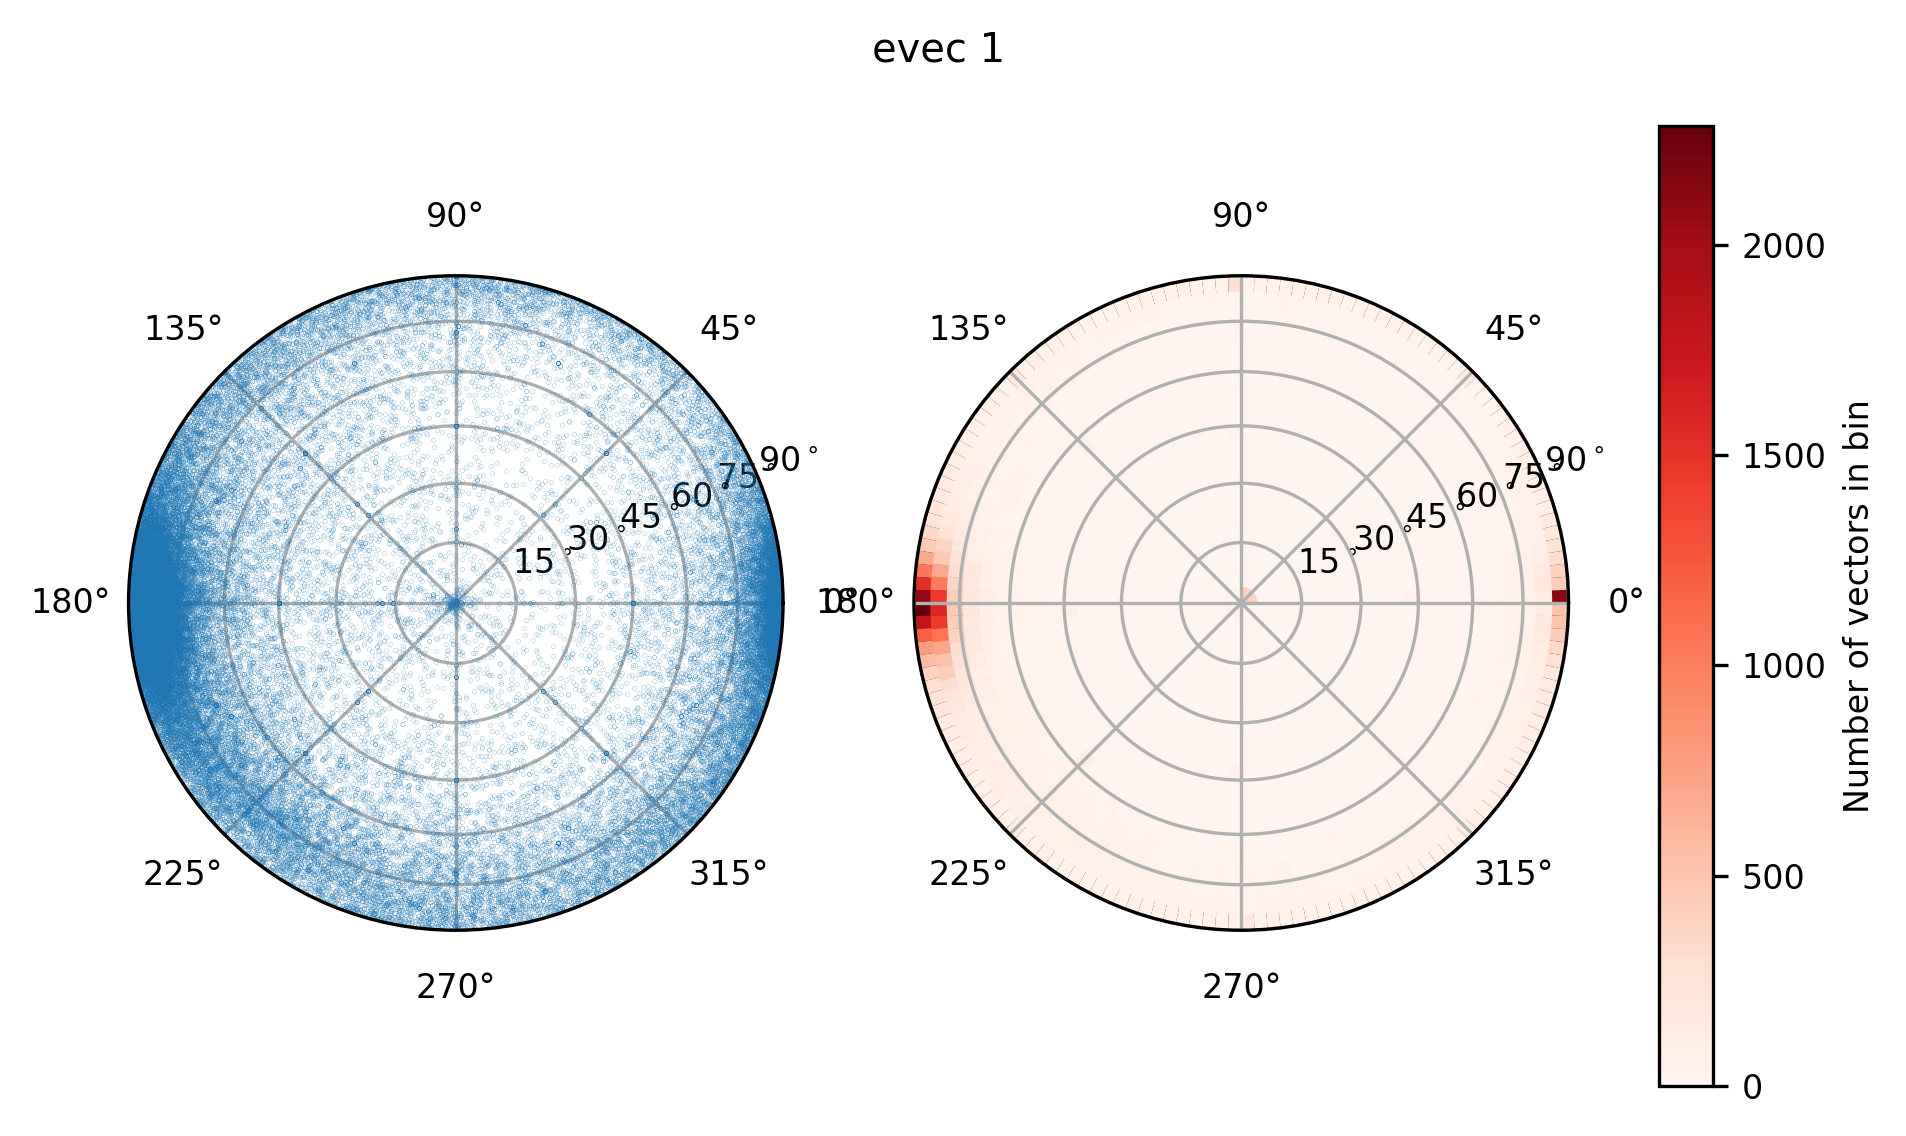

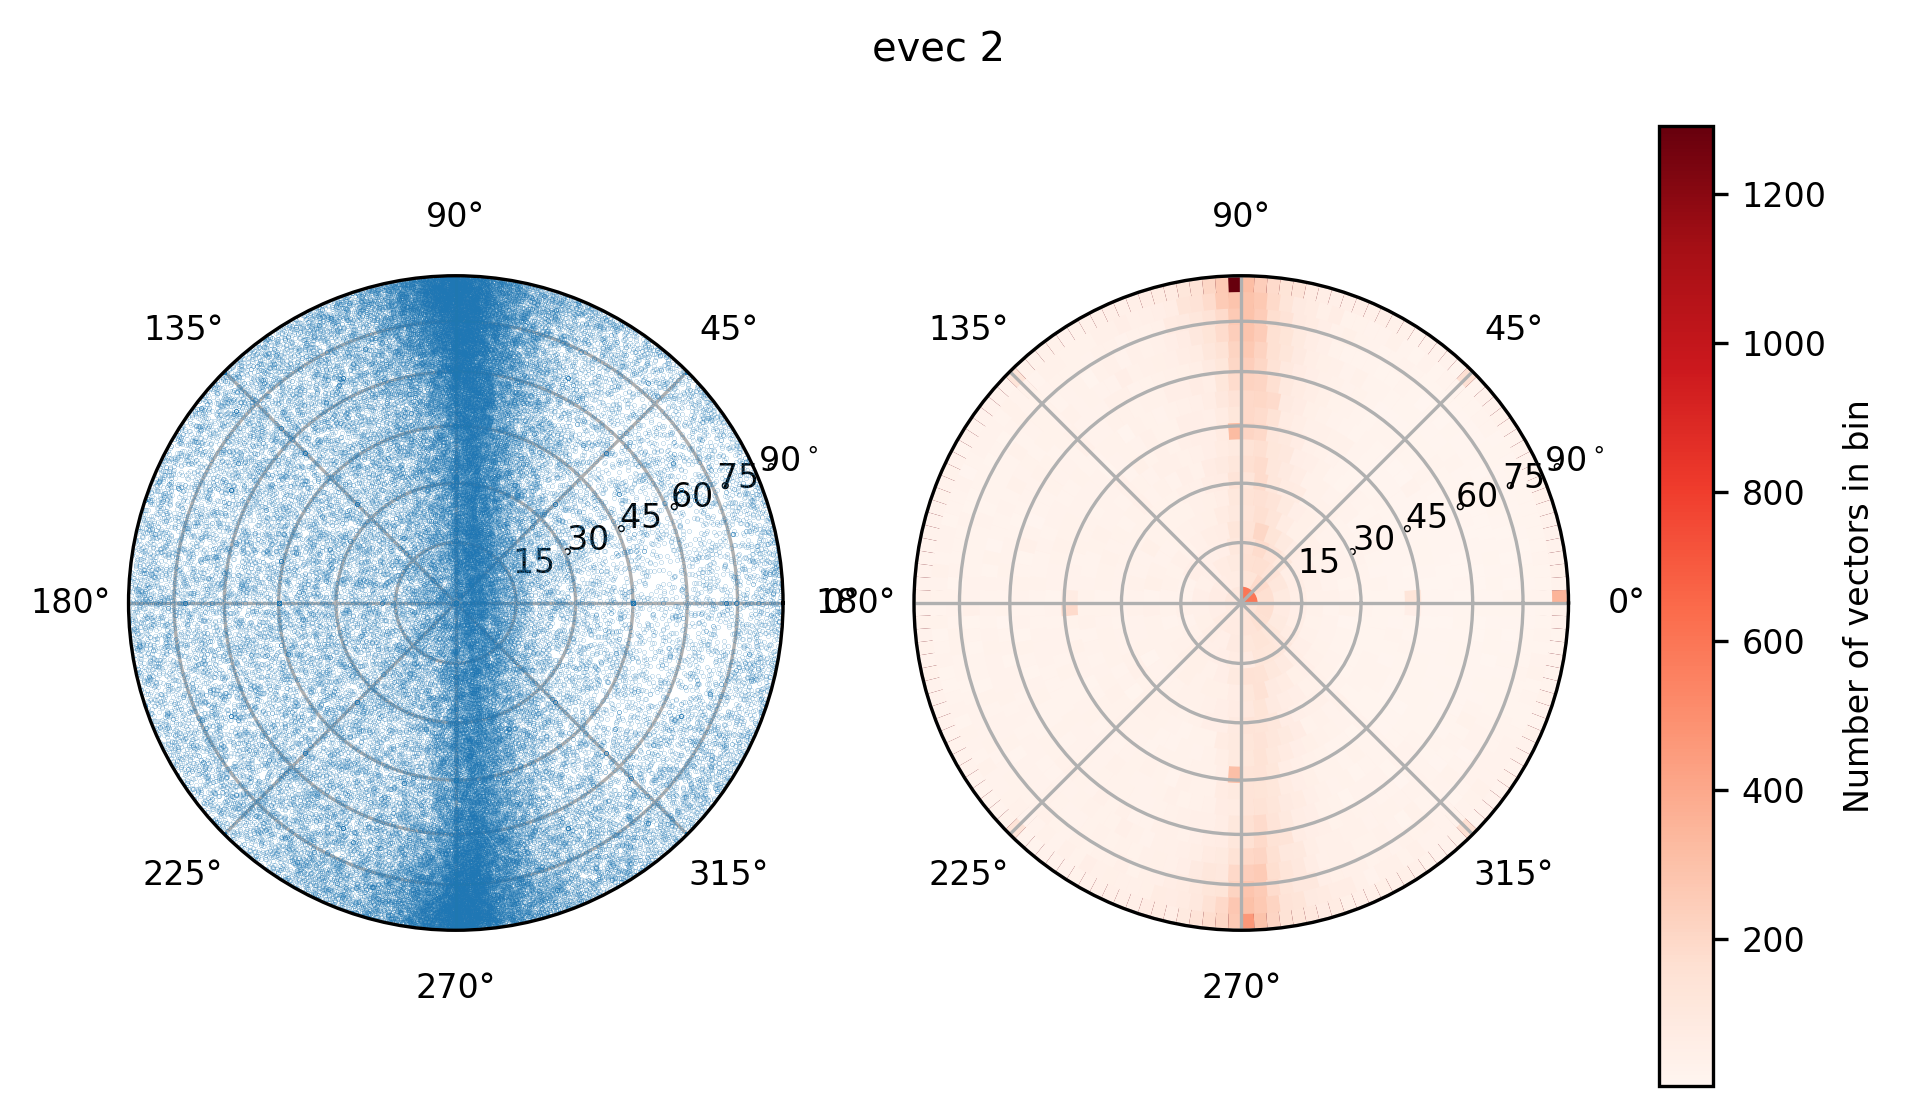

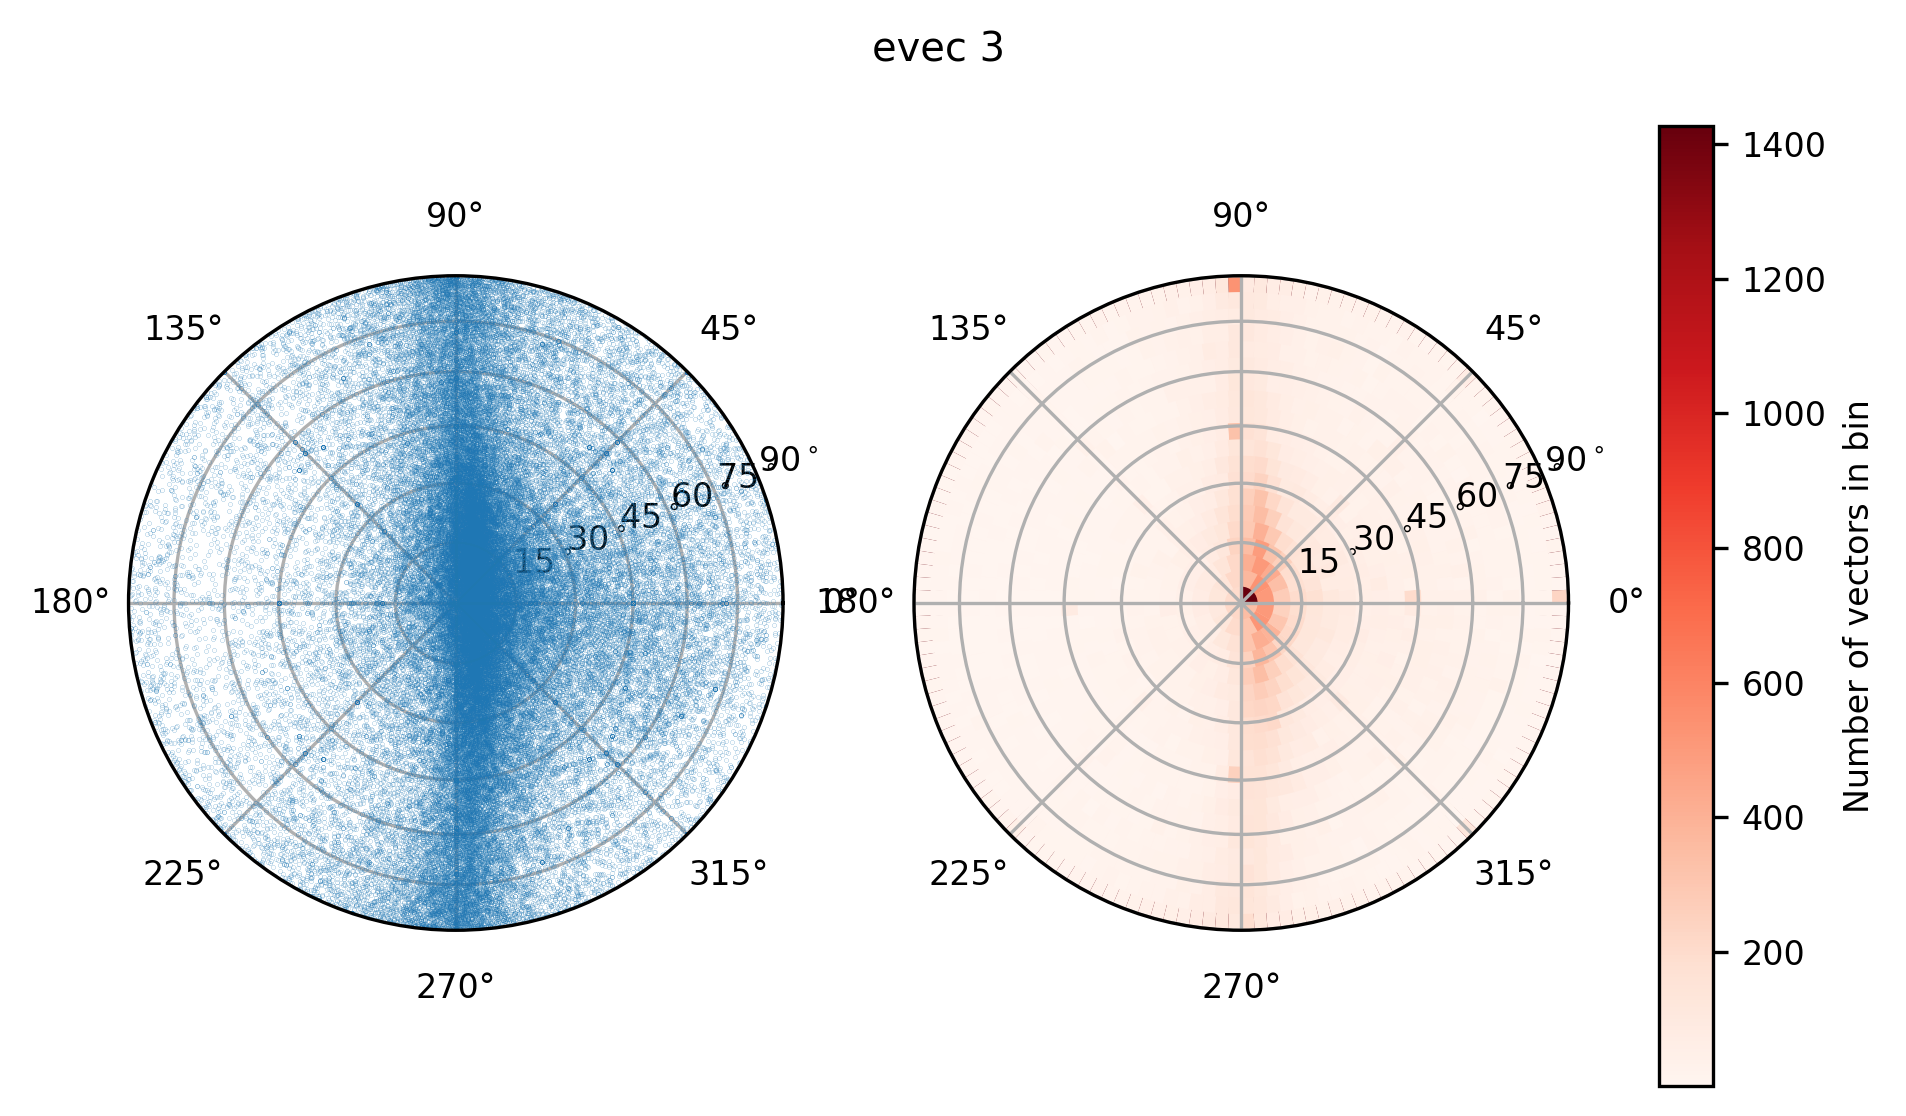

In [160]:
# select which eigenvector to plot
plasma=matplotlib.colormaps['Reds']
spam.plotting.orientationPlotter.plotOrientations(MOIeigenVectors[np.where(MOIeigenVectors[:, 0:3].any(axis=1))[0], 0:3], plot='both', numberOfRings=20, pointMarkerSize=0.1, title='evec 1', cmap=plasma) # evec 1
spam.plotting.orientationPlotter.plotOrientations(MOIeigenVectors[np.where(MOIeigenVectors[:, 3:6].any(axis=1))[0], 3:6], plot='both', numberOfRings=20, pointMarkerSize=0.1, title='evec 2', cmap=plasma) # evec 2
spam.plotting.orientationPlotter.plotOrientations(MOIeigenVectors[np.where(MOIeigenVectors[:, 6:9].any(axis=1))[0], 6:9], plot='both', numberOfRings=20, pointMarkerSize=0.1, title='evec 3', cmap=plasma) # evec 3

There is a strong preferential alingment of the particles along the Z-Y plane.

## Radii of the ellipsoid fitting each particle
We use the `ellipseAxes` method of `spam.label`.

In [22]:
ellipseDimensions = spam.label.ellipseAxes(regions, volumes=pearl_volume, MOIeigenValues=MOIeigenValues)

/home/beats/.conda/envs/spam/lib/python3.9/site-packages/spam/label/label.py:320: RuntimeWarning: invalid value encountered in divide
  ABCaxes[mask, 2] = ((15.0 / (8.0 * numpy.pi)) * numpy.square(Ib[mask] + Ic[mask] - Ia[mask]) / numpy.sqrt((Ia[mask] - Ib[mask] + Ic[mask]) * (Ia[mask] + Ib[mask] - Ic[mask]))) ** (1.0 / 5.0)
/home/beats/.conda/envs/spam/lib/python3.9/site-packages/spam/label/label.py:321: RuntimeWarning: invalid value encountered in sqrt
  ABCaxes[mask, 1] = ((15.0 / (8.0 * numpy.pi)) * numpy.square(Ic[mask] + Ia[mask] - Ib[mask]) / numpy.sqrt((Ib[mask] - Ic[mask] + Ia[mask]) * (Ib[mask] + Ic[mask] - Ia[mask]))) ** (1.0 / 5.0)
/home/beats/.conda/envs/spam/lib/python3.9/site-packages/spam/label/label.py:321: RuntimeWarning: divide by zero encountered in divide
  ABCaxes[mask, 1] = ((15.0 / (8.0 * numpy.pi)) * numpy.square(Ic[mask] + Ia[mask] - Ib[mask]) / numpy.sqrt((Ib[mask] - Ic[mask] + Ia[mask]) * (Ib[mask] + Ic[mask] - Ia[mask]))) ** (1.0 / 5.0)
/home/beats/.conda/e

### Calculate particle degree of anisotrpopy
From the ellipse axes we can calculate an anysotropy factor as the ratio between short and long axes:
`DA = short_radius / large_radius`

In [23]:
DA = ellipseDimensions[1:, 2] / ellipseDimensions[1:, 0]

/tmp/ipykernel_249313/939356124.py:1: RuntimeWarning: invalid value encountered in divide
  DA = ellipseDimensions[1:, 2] / ellipseDimensions[1:, 0]


Anisotropy distribution

Text(0, 0.5, 'Count')

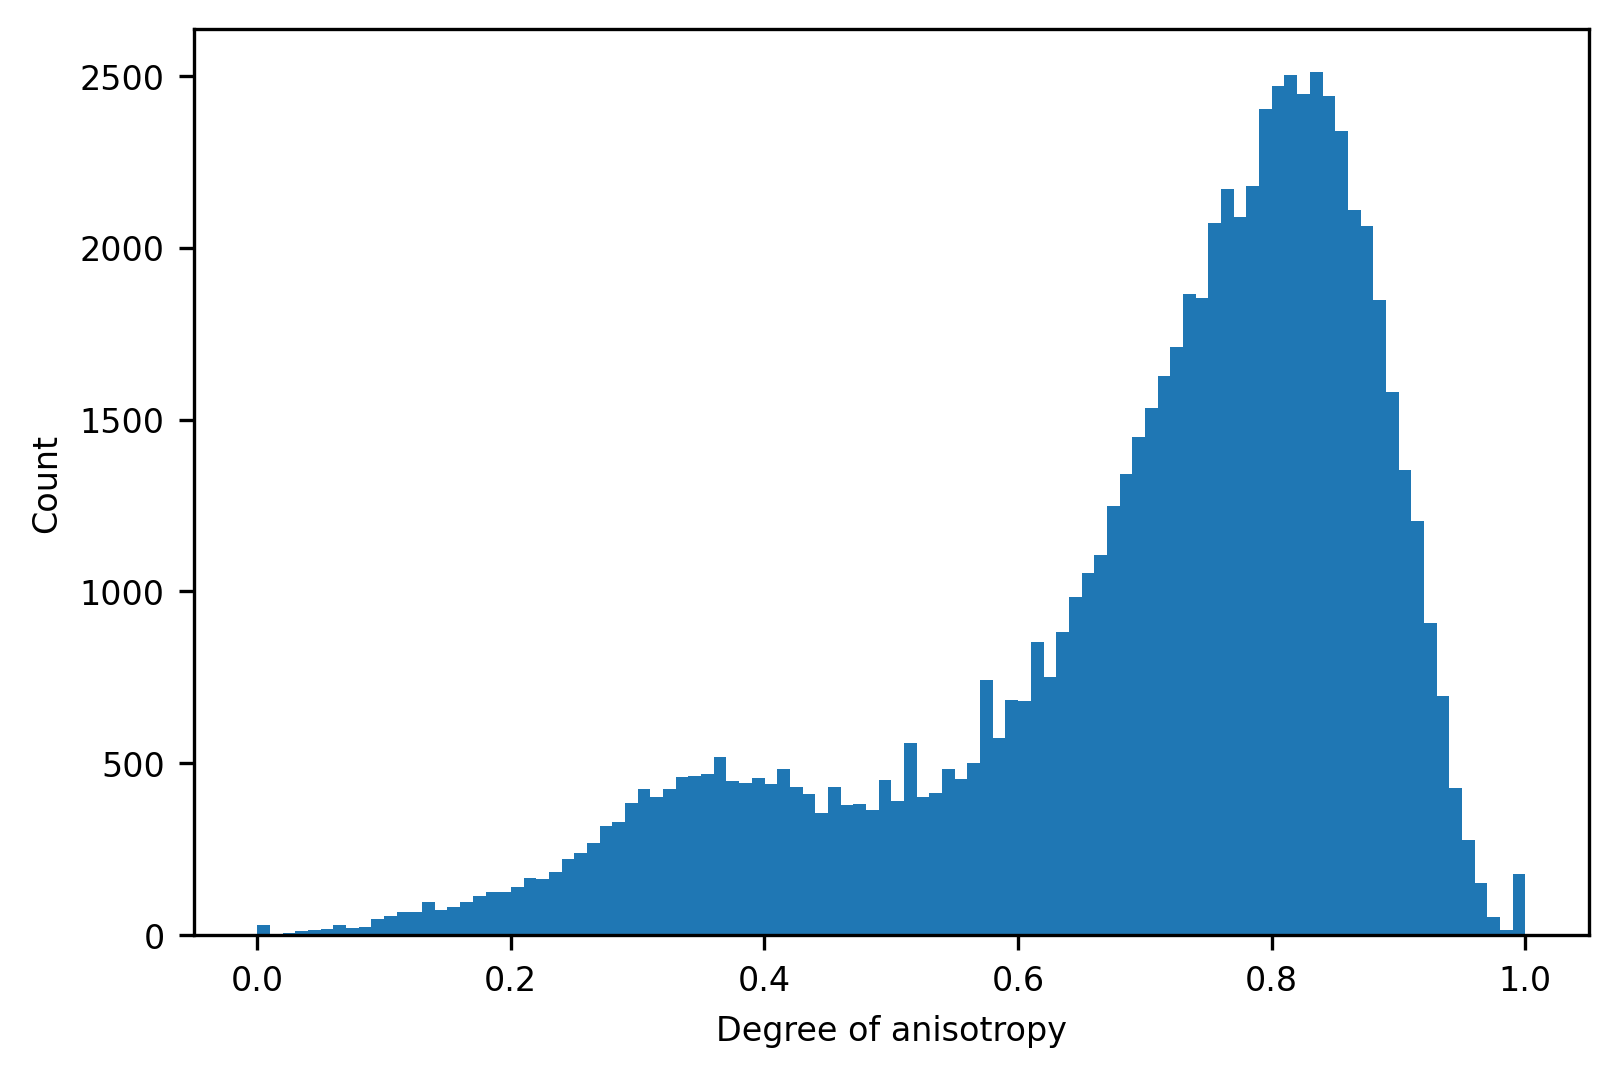

In [56]:
plt.figure()
plt.hist(DA, bins=100)
plt.xlabel("Degree of anisotropy")
plt.ylabel("Count")

### Calculate particle orientation angles

In [58]:
print(MOIeigenValues[1300])
print(MOIeigenVectors[1300, 0:3])

[302072.2  238470.45 228598.36]
[ 0.075 -0.808 -0.584]


In [24]:
# projection_xy = np.ndarray([len(MOIeigenVectors[1:, 6:9]), 2])
# projection_theta_r = np.ndarray([len(MOIeigenVectors[1:, 6:9]), 2])
projection_xy = np.ndarray([len(MOIeigenVectors[1:, 0:3]), 2])
projection_theta_r = np.ndarray([len(MOIeigenVectors[1:, 0:3]), 2])

count = 0

for eVec in MOIeigenVectors[1:, 0:3]:
    projection_xy[count], projection_theta_r[count] = spam.orientations.analyse.projectOrientation(eVec, coordSystem="cartesian", projectionSystem="lambert")
    count += 1

/home/beats/.conda/envs/spam/lib/python3.9/site-packages/spam/orientations/analyse.py:354: RuntimeWarning: invalid value encountered in divide
  theta = math.acos(z / r)  # inclination


- `projection_theta_r[:, 0]`: inclination angle in the XY-plane (in radiants)
- `projection_theta_r[:, 1]`: inclination angle with respect to the Z-axis (in radiants)

Calculate angle from X-axis (theta) (0-90 deg.)

In [25]:
theta = np.ndarray([len(projection_theta_r)])
count = 0
for angle in projection_theta_r[:,0]:
    if abs(angle) > np.pi/2:
        theta[count] = np.pi - abs(angle)
    else:
        theta[count] = abs(angle)
    count += 1

Convert theta to degree

In [26]:
projection_theta_r = 180*projection_theta_r/np.pi
theta = 180*theta/np.pi

Plot histogram of orientation angles

Text(0, 0.5, 'Count')

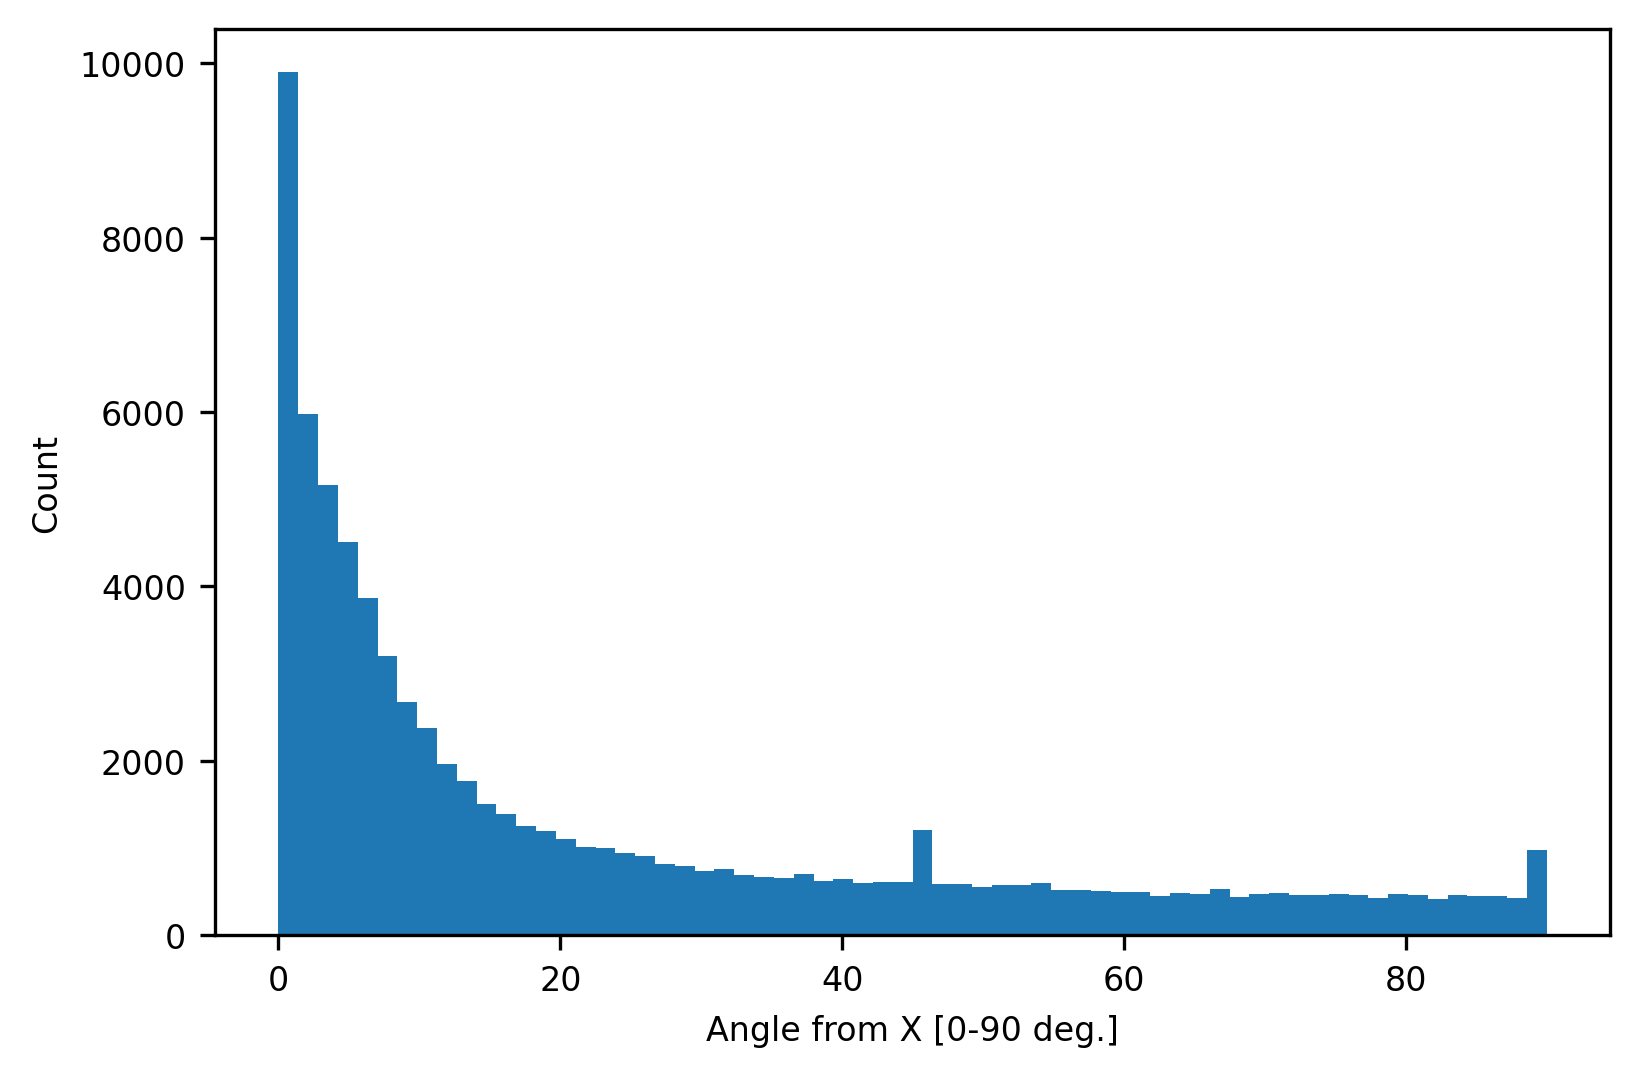

In [65]:
plt.figure()
plt.hist(theta, bins=64)
plt.xlabel("Angle from X [0-90 deg.]")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

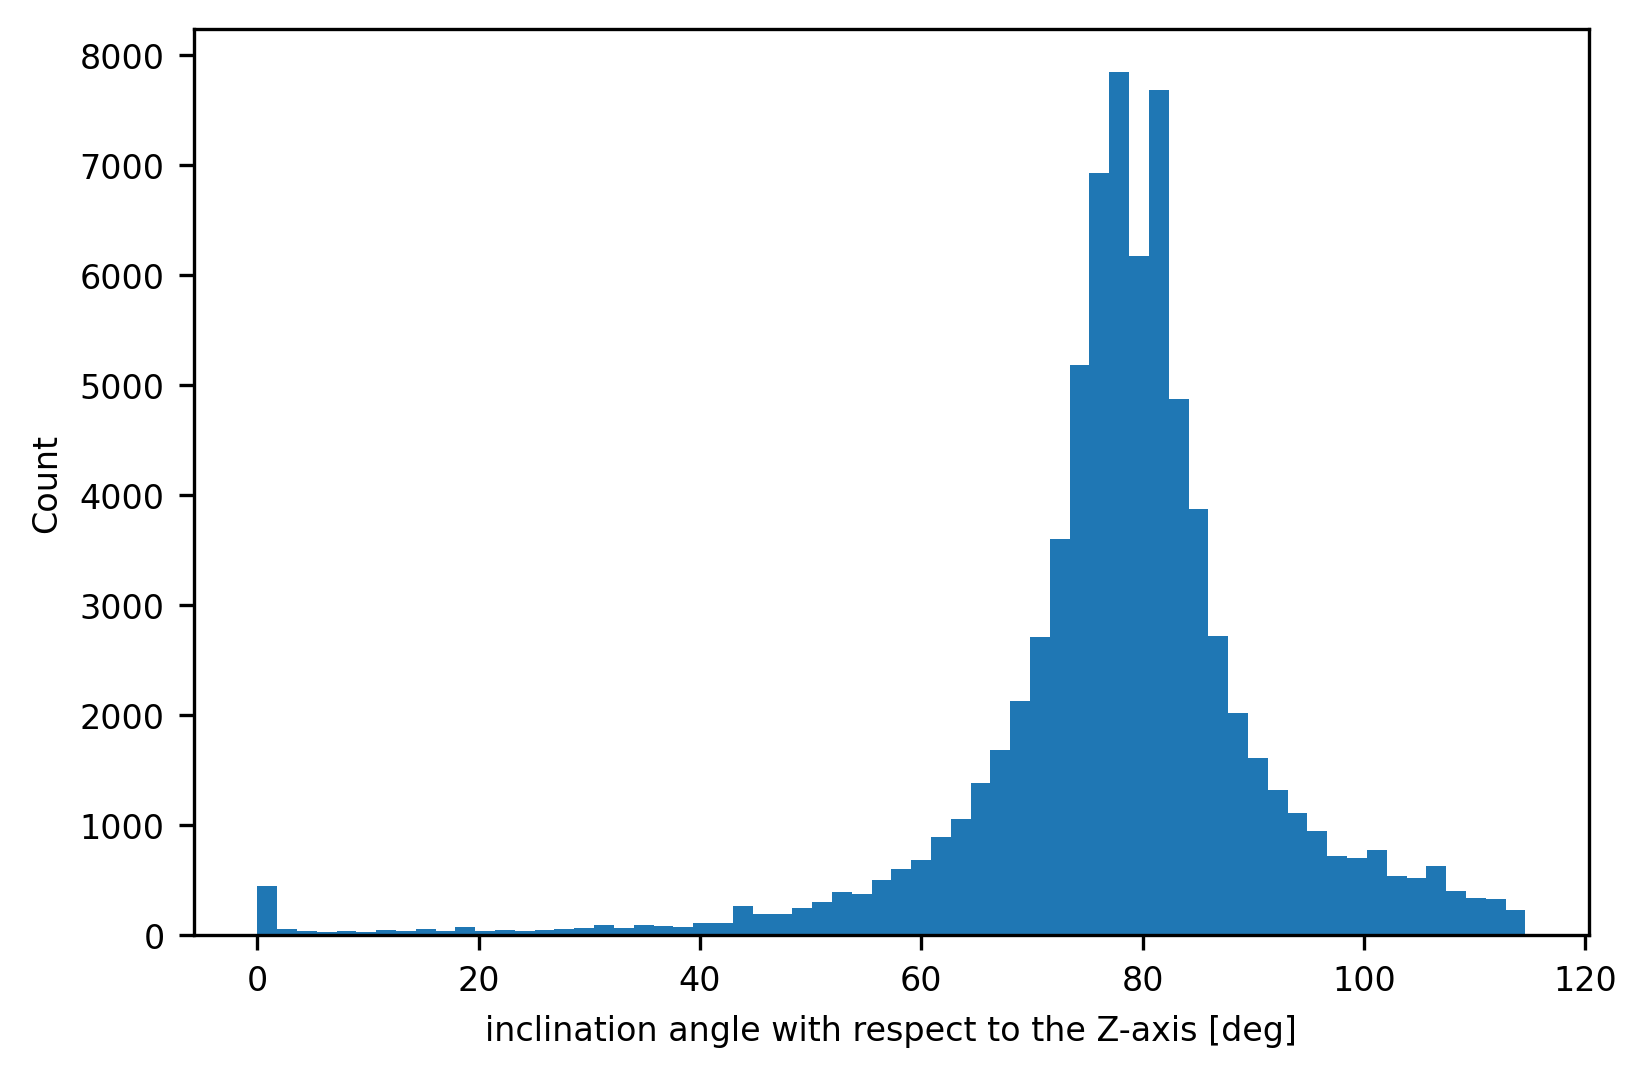

In [66]:
plt.figure()
plt.hist(projection_theta_r[:, 1], bins=64)
plt.xlabel("inclination angle with respect to the Z-axis [deg]")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

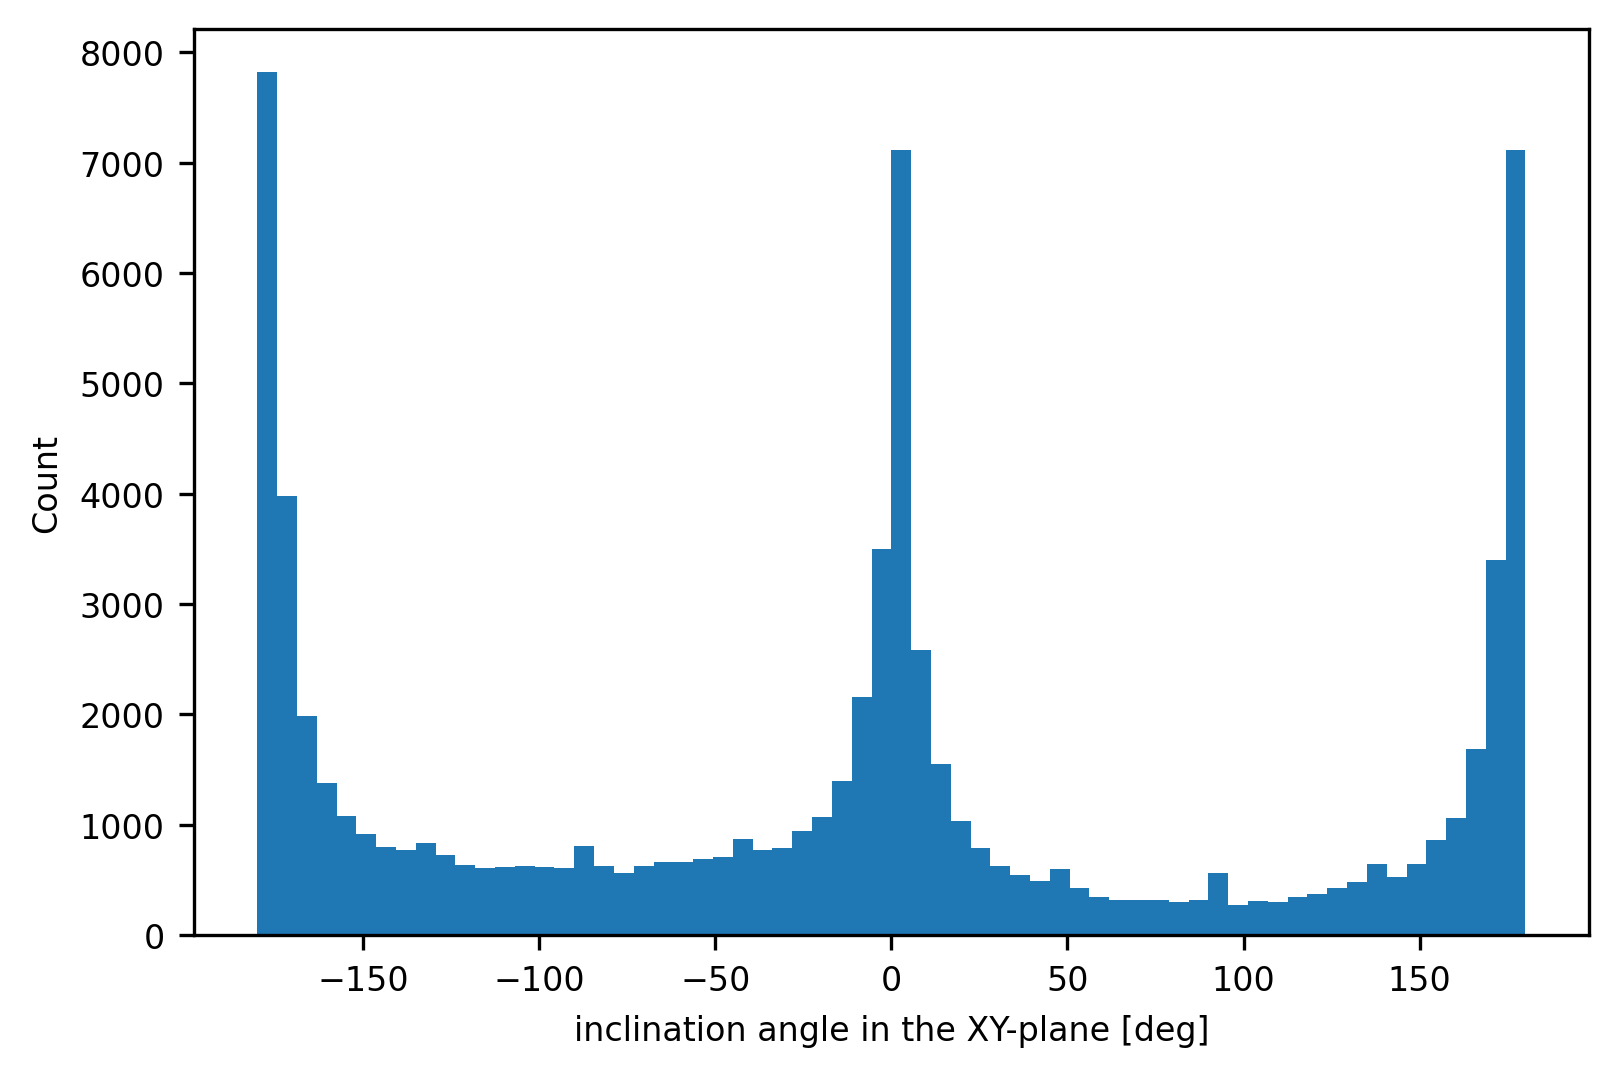

In [67]:
plt.figure()
plt.hist(projection_theta_r[:, 0], bins=64)
plt.xlabel("inclination angle in the XY-plane [deg]")
plt.ylabel("Count")

## Particles distance from pit corrosion front
The distance to the corrosion front is an indication of the particle age.

Load mask of the pit front (the mask that we load was downscaled with resampling factor 2)

In [7]:
mask_file = work_folder+"/masks/pit_crop_front_res2/slice_00000.tiff"

In [8]:
BW_pit_front = read_tiff_stack(mask_file)

### Compute distance transform from the pit front

In [9]:
dist = ndimage.distance_transform_edt(~BW_pit_front)

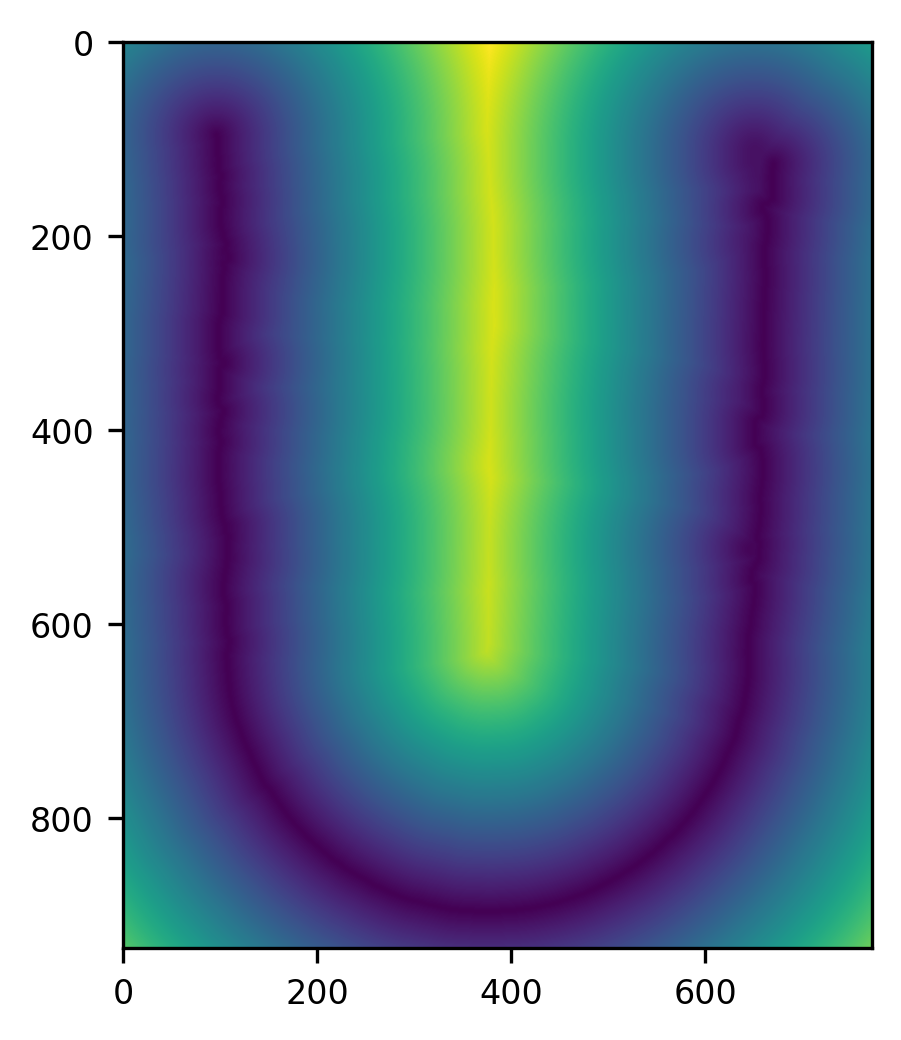

In [12]:
plt.imshow(dist[1000,:,:])

#### Save the distance transform image

In [13]:
dist_file = work_folder+"/masks/pit_crop_front_res2_dist/slice.tiff"

In [14]:
dxchange.write_tiff_stack(dist, dist_file)

#### Reload the distance transform image

In [14]:
if 'dist' not in globals():
    dist = read_tiff_stack(dist_file)

### Find the distance from the corrosion front at each particle center of mass
The distance transform image that we use has been downscaled with factor 2. Hence also the coordinates of the particles center of mass must be divided by 2.

In [27]:
COM_coors = np.round(centresOfMass/2).astype(int)

In [28]:
distances_pit_bottom = np.ndarray(COM_coors.shape[0])
count = 0
for COM in COM_coors:
    distances_pit_bottom[count] = dist[COM[0], COM[1], COM[2]] * 2
    count = count + 1

#### Plot histogram of the particle distance from the pit front

In [ ]:
kde = stats.gaussian_kde(distances_pit_bottom)
x = np.linspace(distances_pit_bottom.min(), distances_pit_bottom.max(), 100)
p = kde(x)

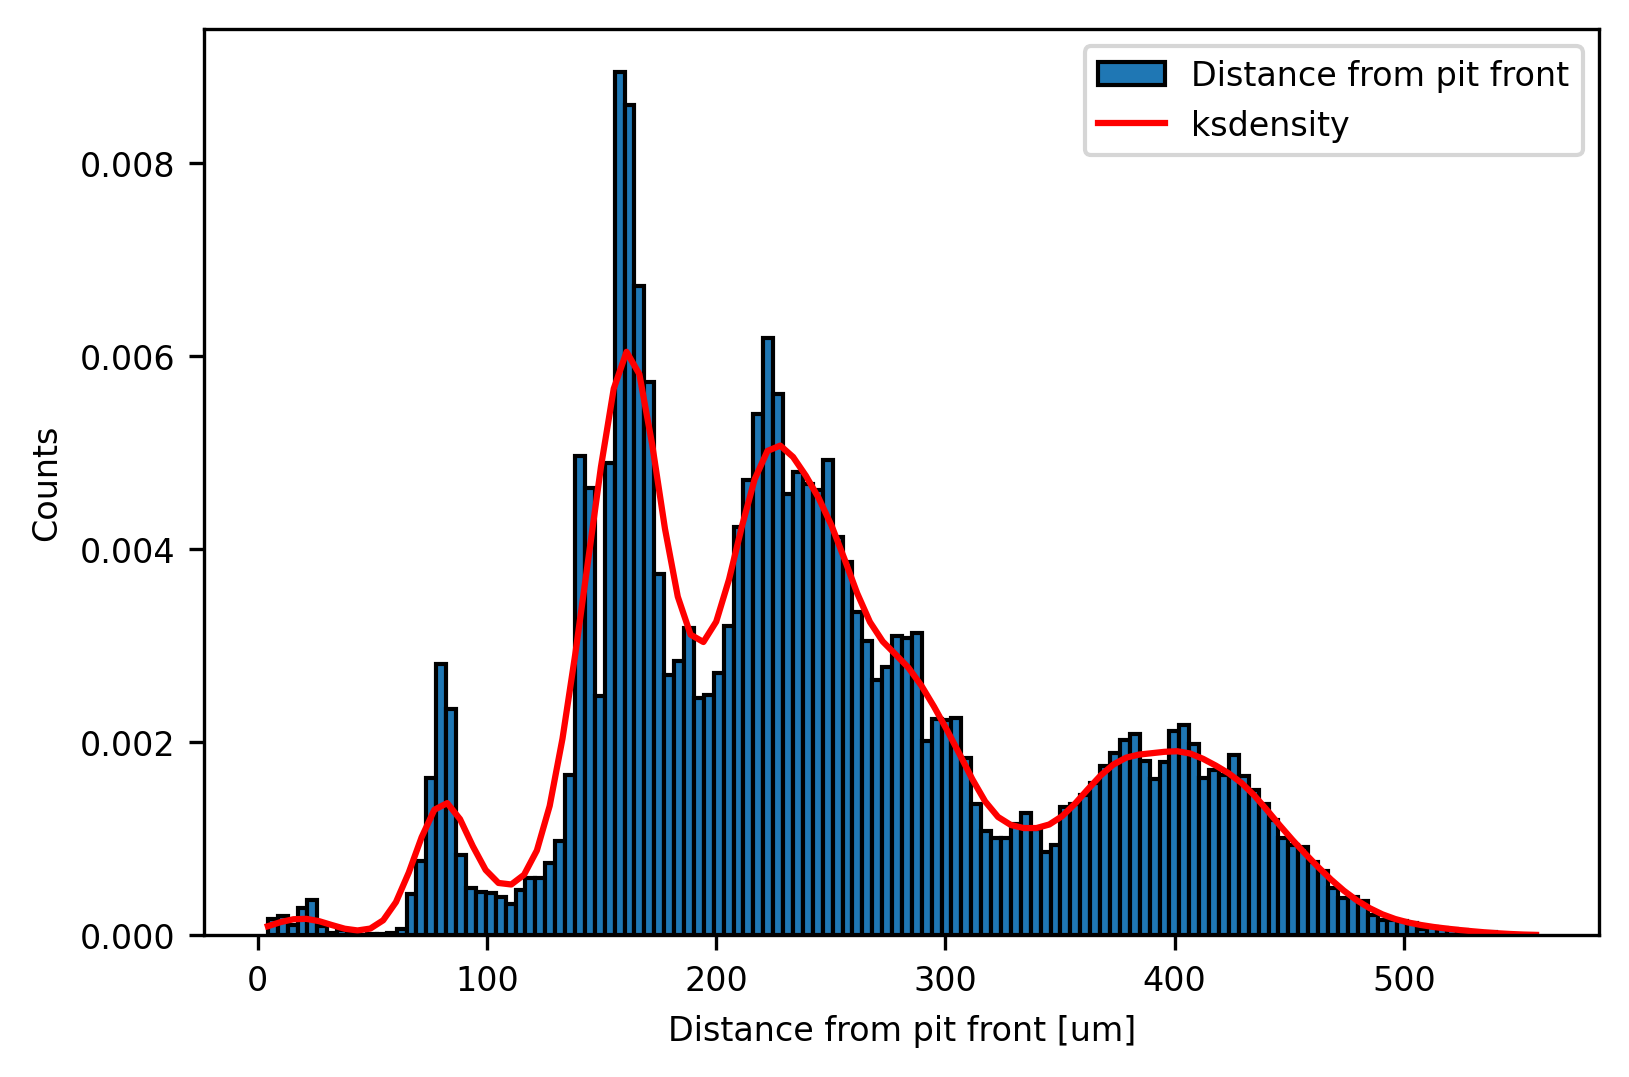

In [169]:
plt.figure()
plt.hist(distances_pit_bottom, bins=128, edgecolor="k", density=True, label='Distance from pit front')
plt.plot(x, p, 'r', label='ksdensity')
plt.xlabel("Distance from pit front [um]")
plt.ylabel("Counts")
plt.legend()

### Plot particle age VS particle volume (or sphericity)
> Do the deposits change in volume and shape with age?

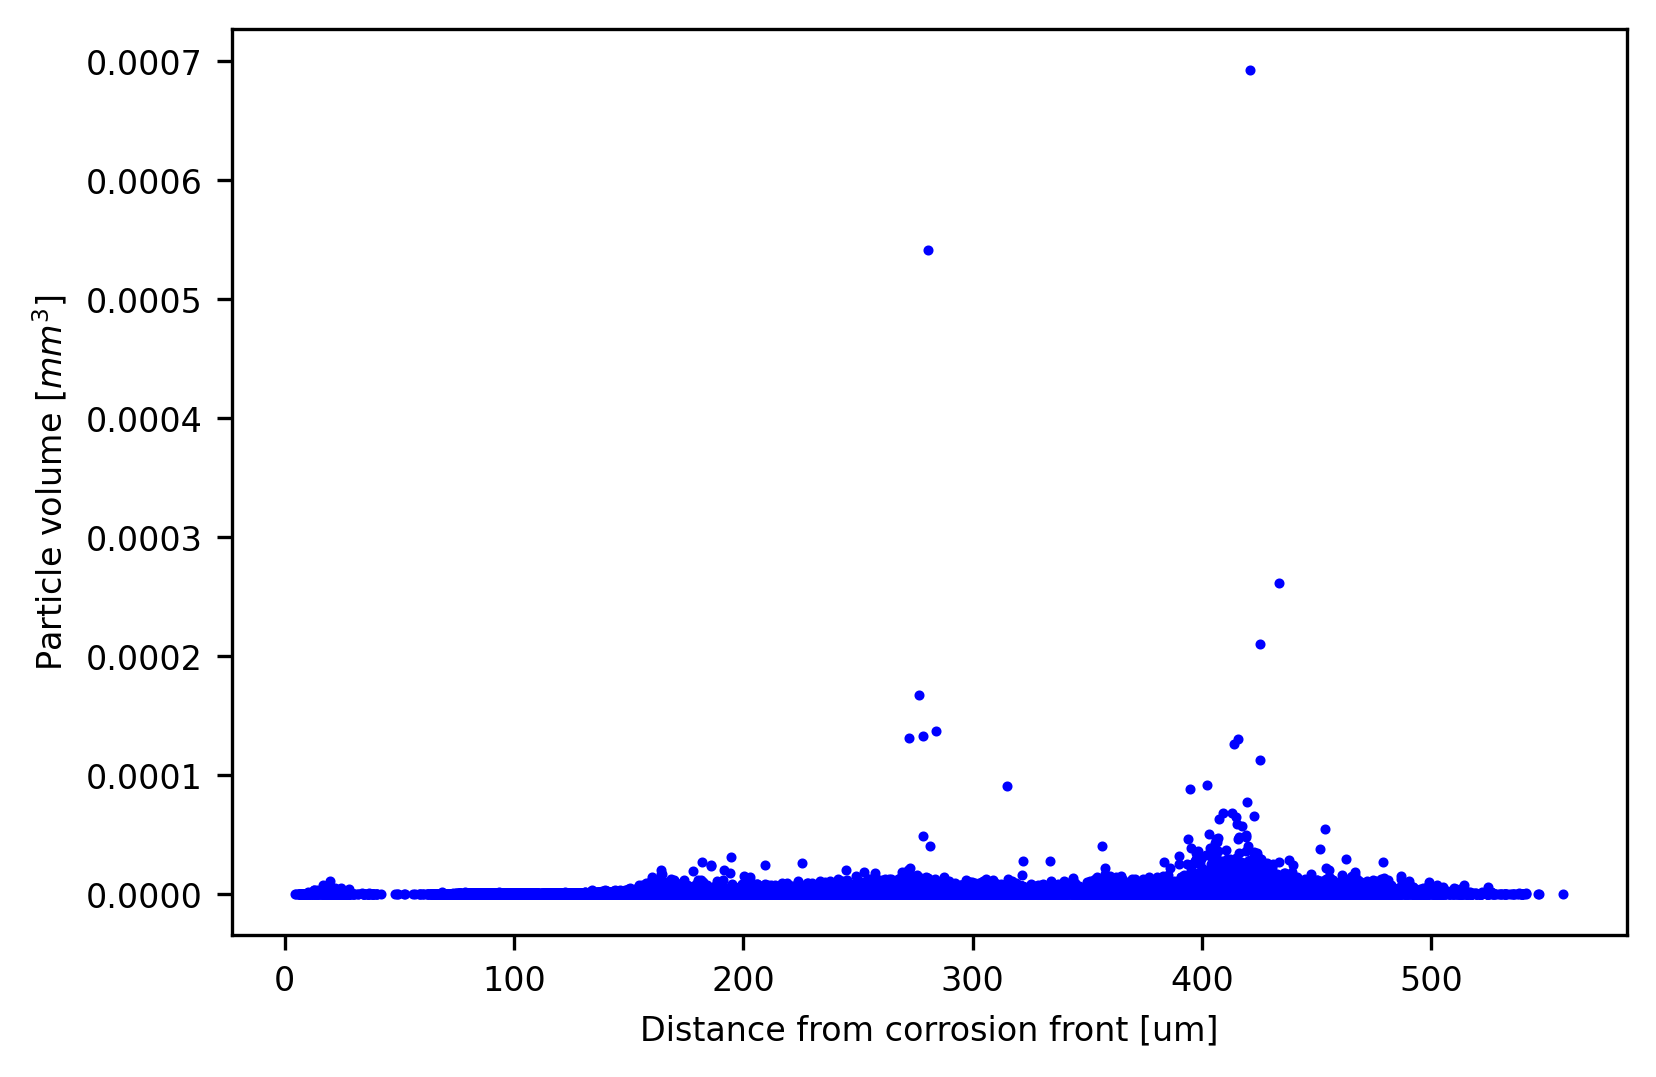

In [42]:
plt.scatter(distances_pit_bottom, pearl_volume*1e-9, s=2, c="b")
plt.xlabel("Distance from corrosion front [um]")
plt.ylabel("Particle volume [$mm^3$]")
plt.show()

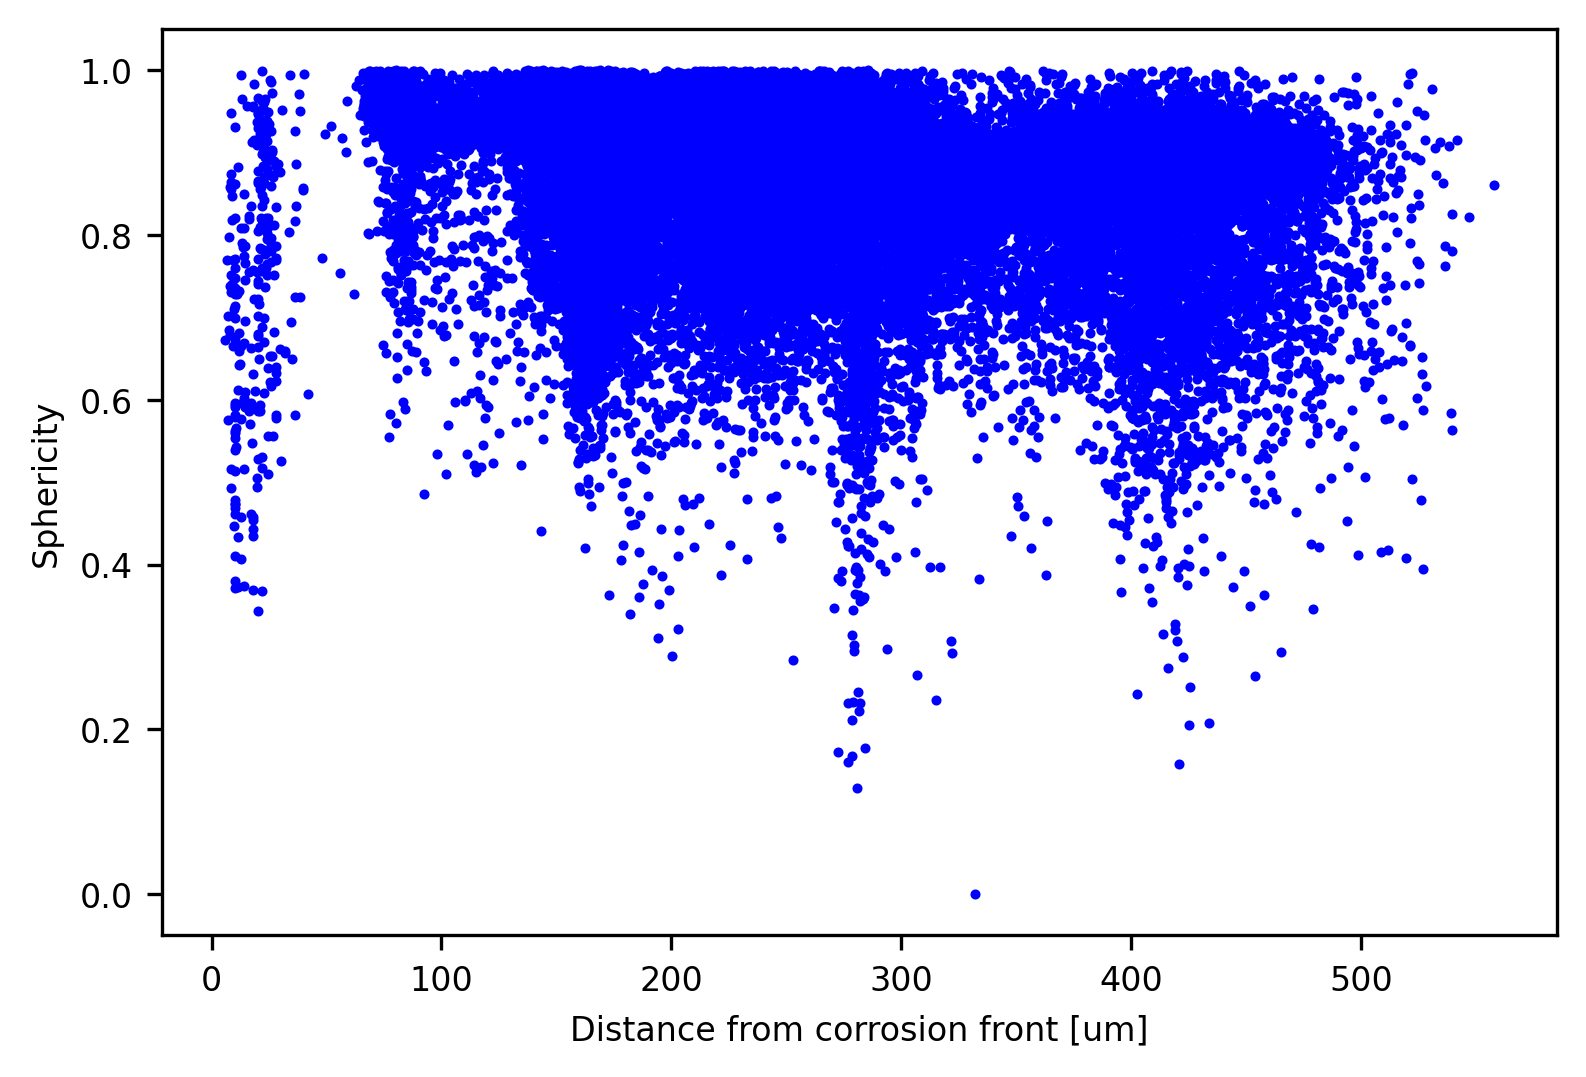

In [45]:
plt.scatter(distances_pit_bottom[sphericity<=1], sphericity[sphericity<=1], s=2, c="b")
plt.xlabel("Distance from corrosion front [um]")
plt.ylabel("Sphericity")
plt.show()

### Plot particle size VS particle shape (sphericity)
> Assumption: particles become more elongated and anisotropic as they grow..

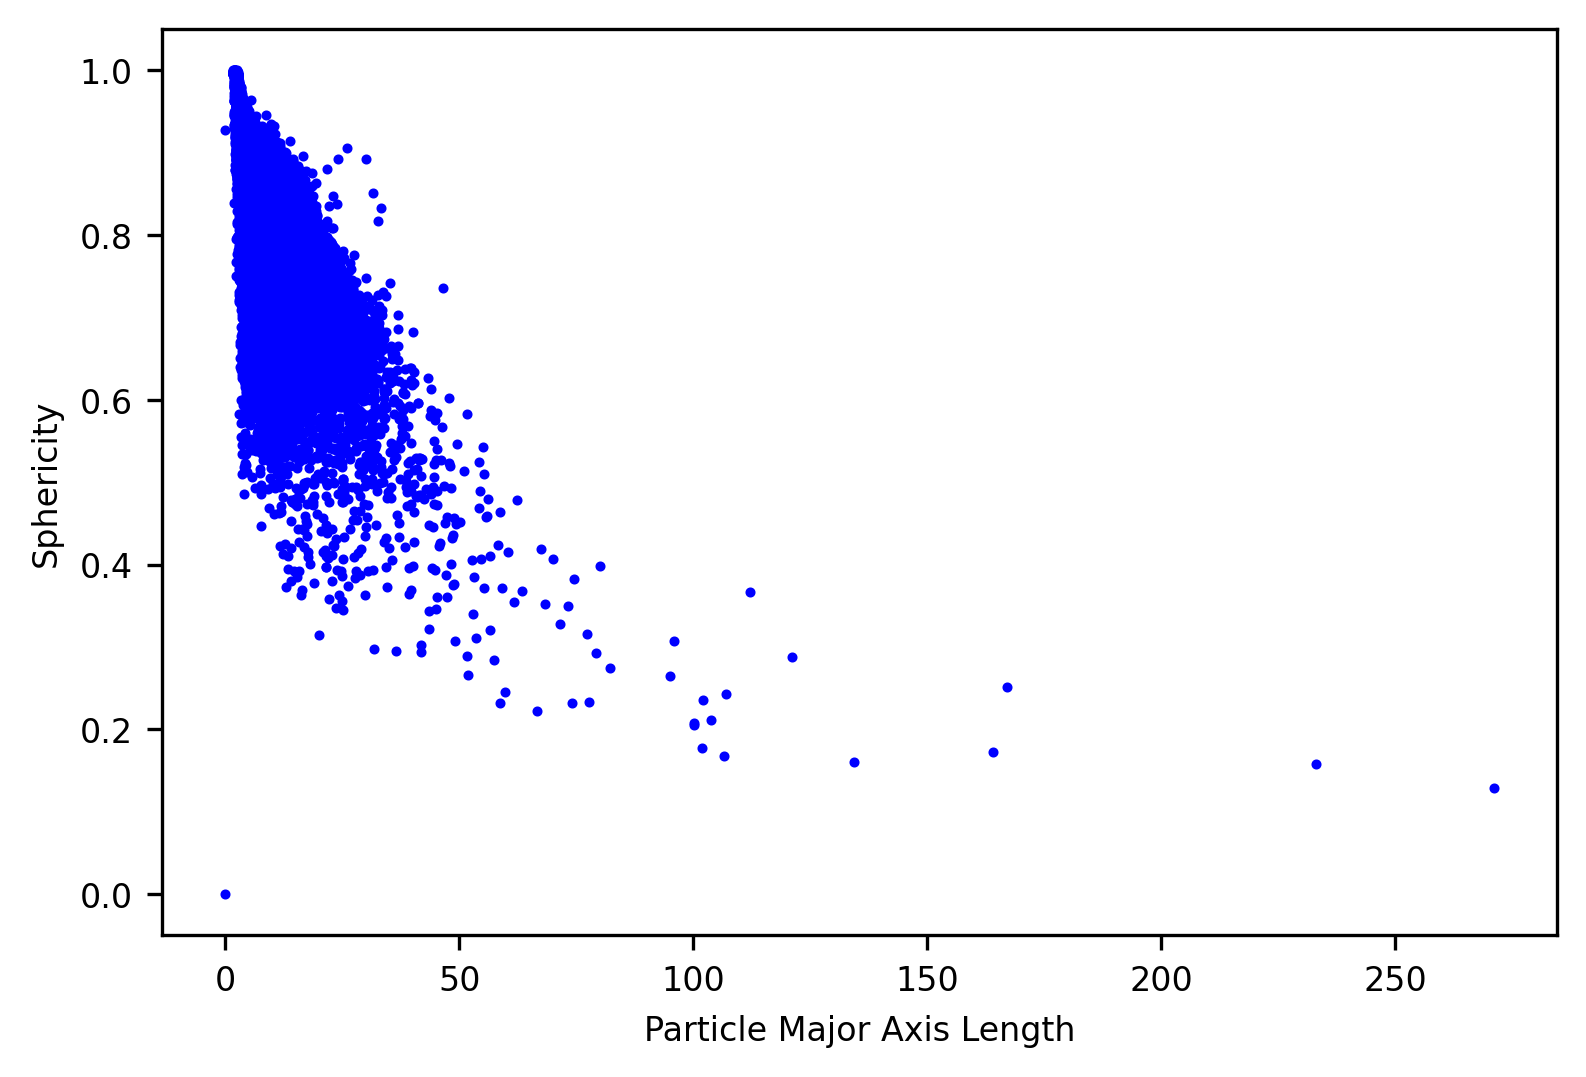

In [56]:
plt.scatter(ellipseDimensions[sphericity<=1, 0], sphericity[sphericity<=1], s=2, c="b")
plt.xlabel("Particle Major Axis Length")
plt.ylabel("Sphericity")
plt.show()

## Particles distance from voids
> Hypothesis: particles form mainly within the voids of layered structure

Load mask of the voids within the pit

In [33]:
input_file = work_folder+'/masks/voids_crop/slice_0001.tif'

In [34]:
BW_voids = read_tiff_stack(input_file)

Downscale the mask with factor 2

In [35]:
downsample_factor = 2
BW_voids = ndimage.zoom(BW_voids, 1/downsample_factor, order=2, mode='reflect')

In [36]:
BW_voids = BW_voids >= 128

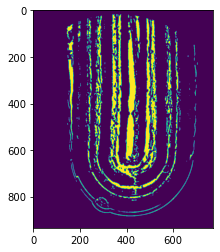

In [37]:
plt.imshow(BW_voids[1575,:,:])

### Compute distance transform from void regions

In [72]:
dist_voids = ndimage.distance_transform_edt(~BW_voids)

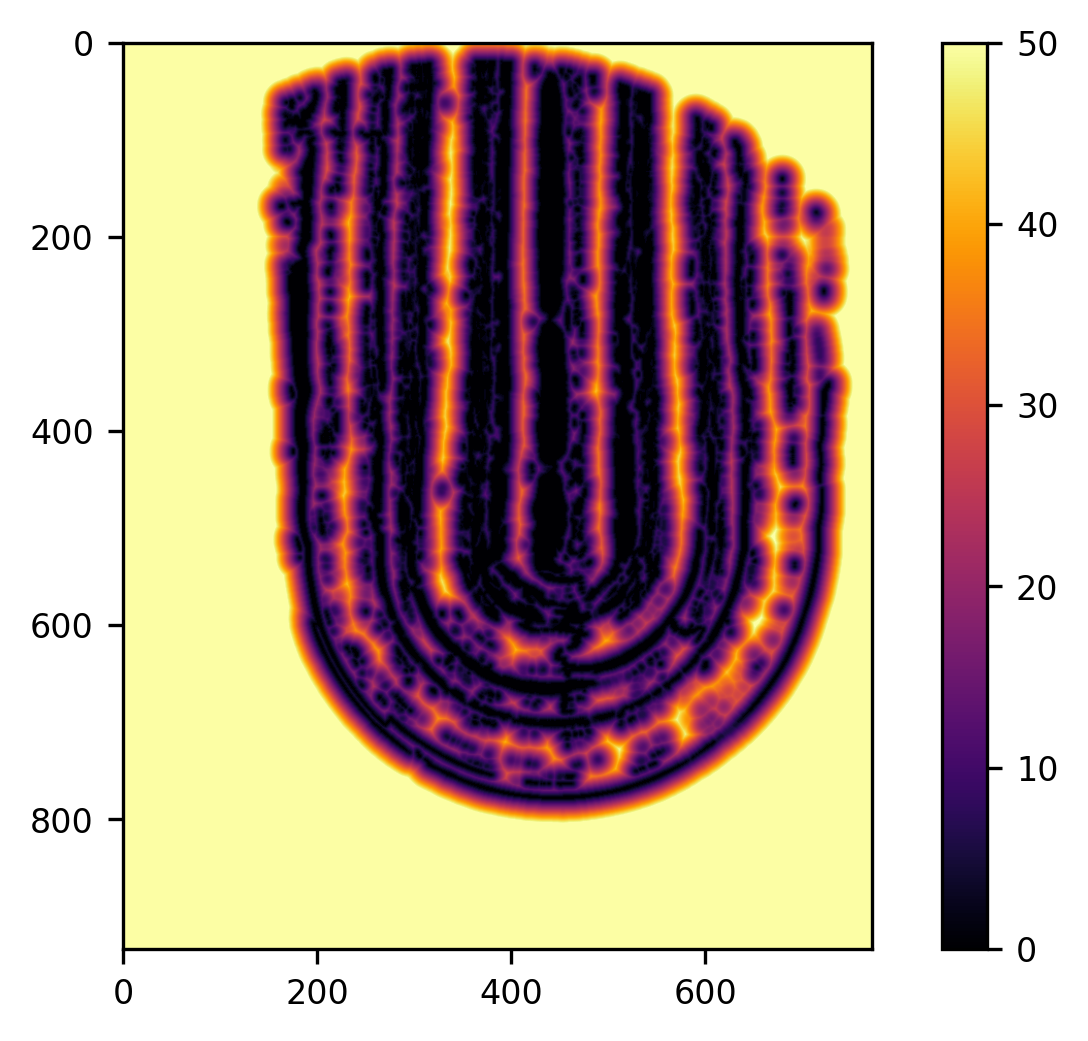

In [116]:
plt.imshow(2*dist_voids[1875,:,:], cmap='inferno', vmax=50)
plt.colorbar()

#### Save the distance transform image

In [117]:
dist_file = work_folder+"/masks/voids_crop_res2_dist/slice.tiff"

In [118]:
dxchange.write_tiff_stack(dist_voids, dist_file)

#### Reload distance transform image
Only if you didn't run the previous section of this notebook

In [30]:
if 'dist_voids' not in globals():
    dist_voids = read_tiff_stack(work_folder+"/masks/voids_crop_res2_dist/slice.tiff")

### Find the distance from pit voids at each particle center of mass
The distance transform image that we use has been downscaled with factor 2. Hence also the coordinates of the particles center of mass must be divided by 2.

In [31]:
distances_voids = np.ndarray(COM_coors.shape[0])
count = 0
for COM in COM_coors:
    distances_voids[count] = dist_voids[COM[0], COM[1], COM[2]] * 2
    count = count + 1

#### Plot histogram and Cumulative Density Function (CFD) of the particle distance from corrosion front

In [85]:
n_bins = 128
h, bins = np.histogram(distances_voids, bins=n_bins)

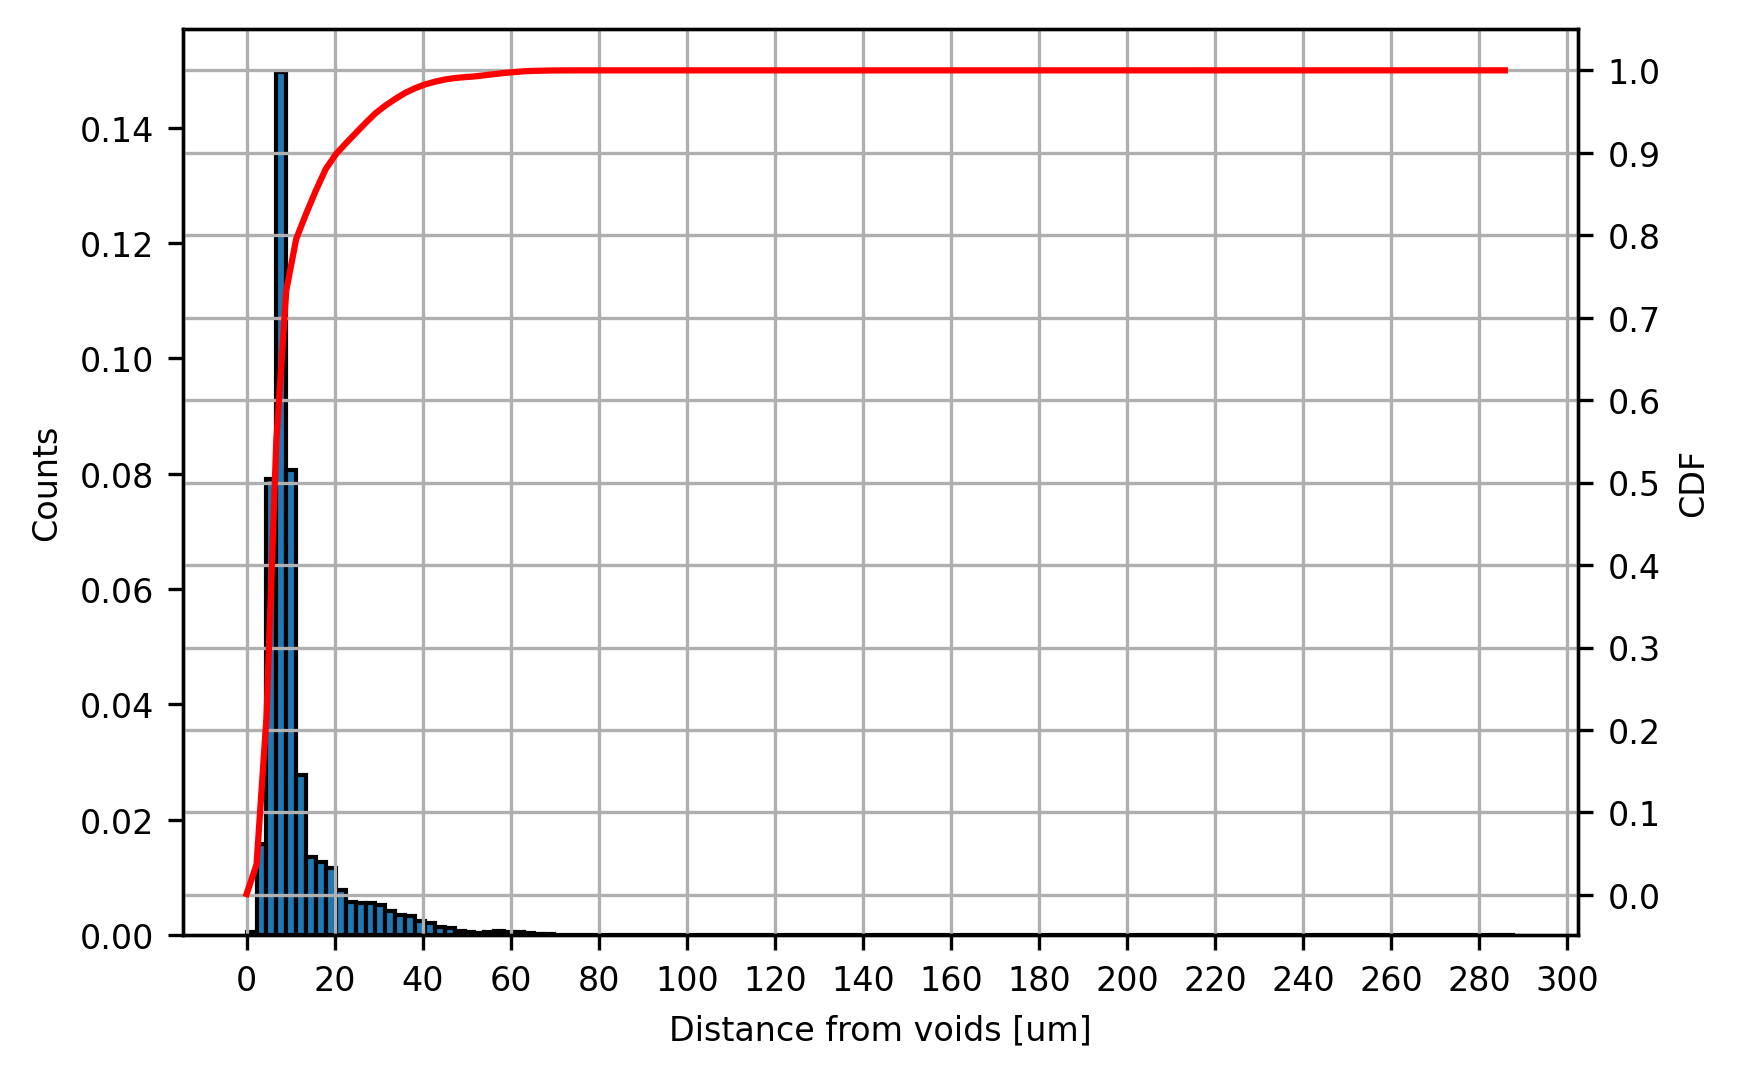

In [110]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.hist(distances_voids, bins=n_bins, edgecolor="k", alpha=1, density=True, label='Distance from voids')
ax1.plot(bins[:-1], np.cumsum(h)/np.max(np.cumsum(h)), 'r')
ax.set_xlabel("Distance from voids [um]")
ax.set_xticks(np.arange(0, 320, 20))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylabel("Counts")
ax1.set_ylabel('CDF')
ax1.grid(which='both')
ax.grid(axis='x')

**90% of the particles is within 20 microns from a void area!!**

### Plot the distance of voids within the pit from the pit front
The distance transform image that we use has been downscaled with factor 2. Hence all distances must be multiplied by 2.

In [38]:
voids_dist_front = 2 * dist[BW_voids]

In [177]:
kde2 = stats.gaussian_kde(voids_dist_front)
x2 = np.linspace(voids_dist_front.min(), voids_dist_front.max(), 100)
p2 = kde2(x2)

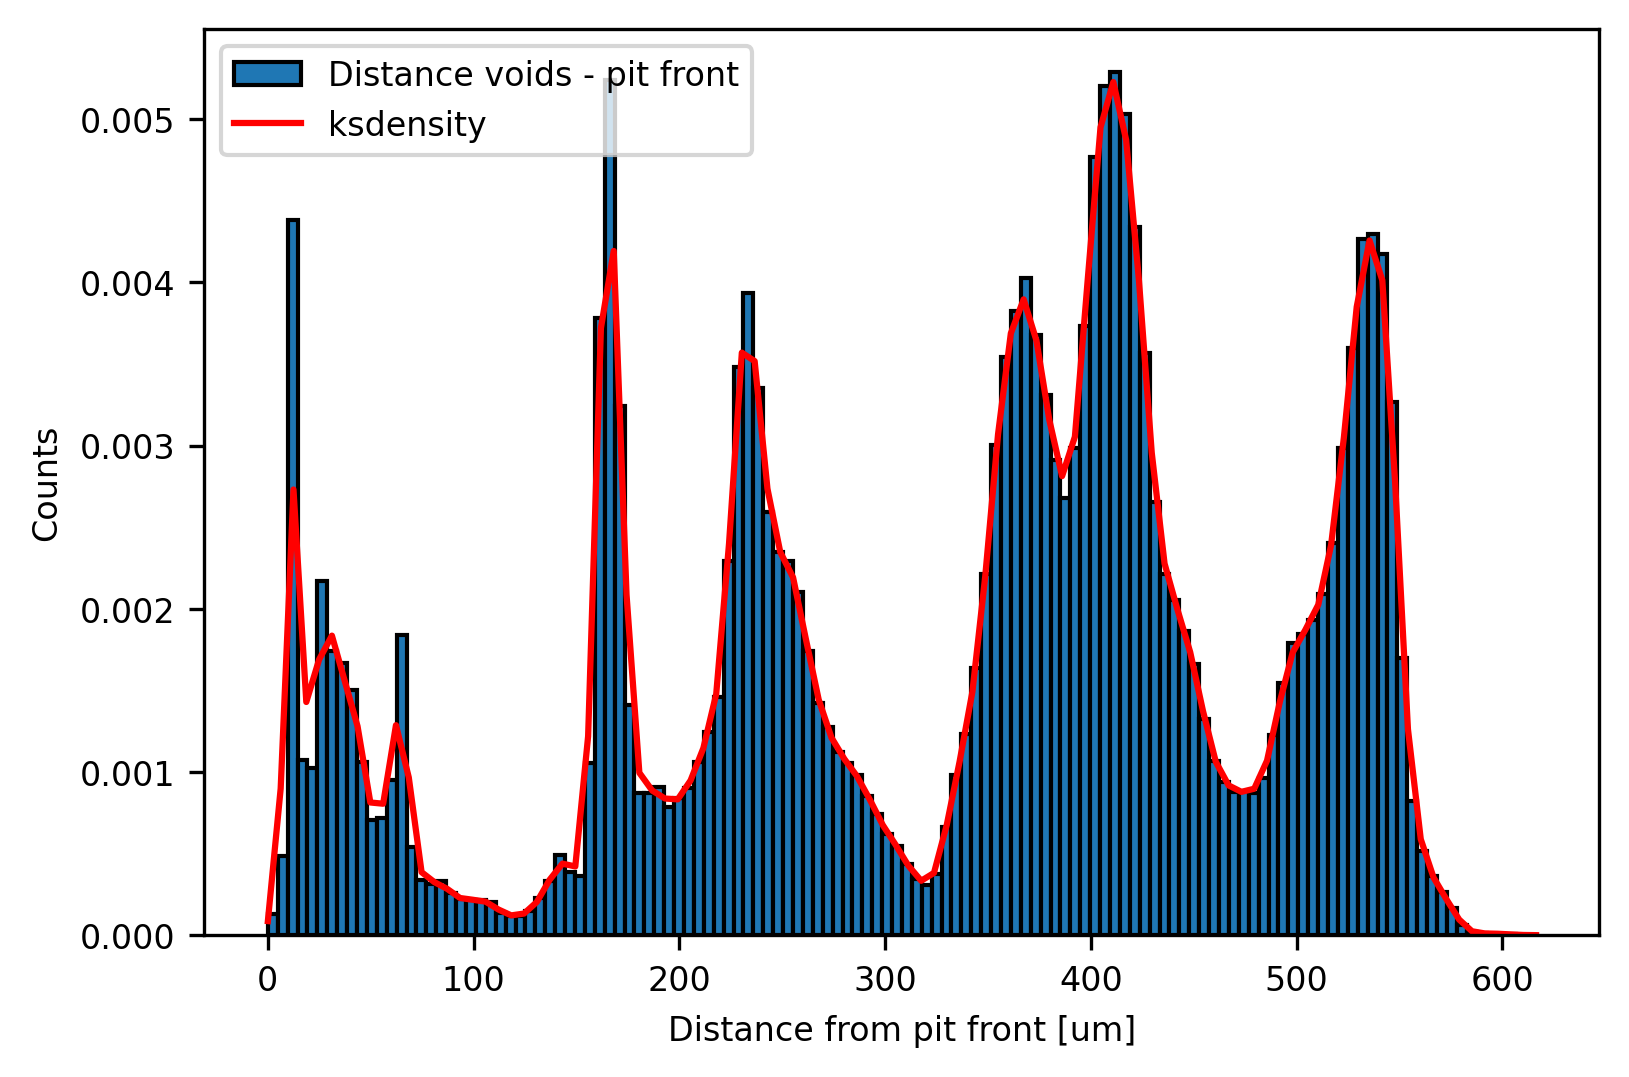

In [137]:
plt.figure()
plt.hist(voids_dist_front, bins=128, edgecolor="k", density=True, label='Distance voids - pit front')
plt.plot(x2, p2, 'r', label='ksdensity')
plt.xlabel("Distance from pit front [um]")
plt.ylabel("Counts")
plt.legend()

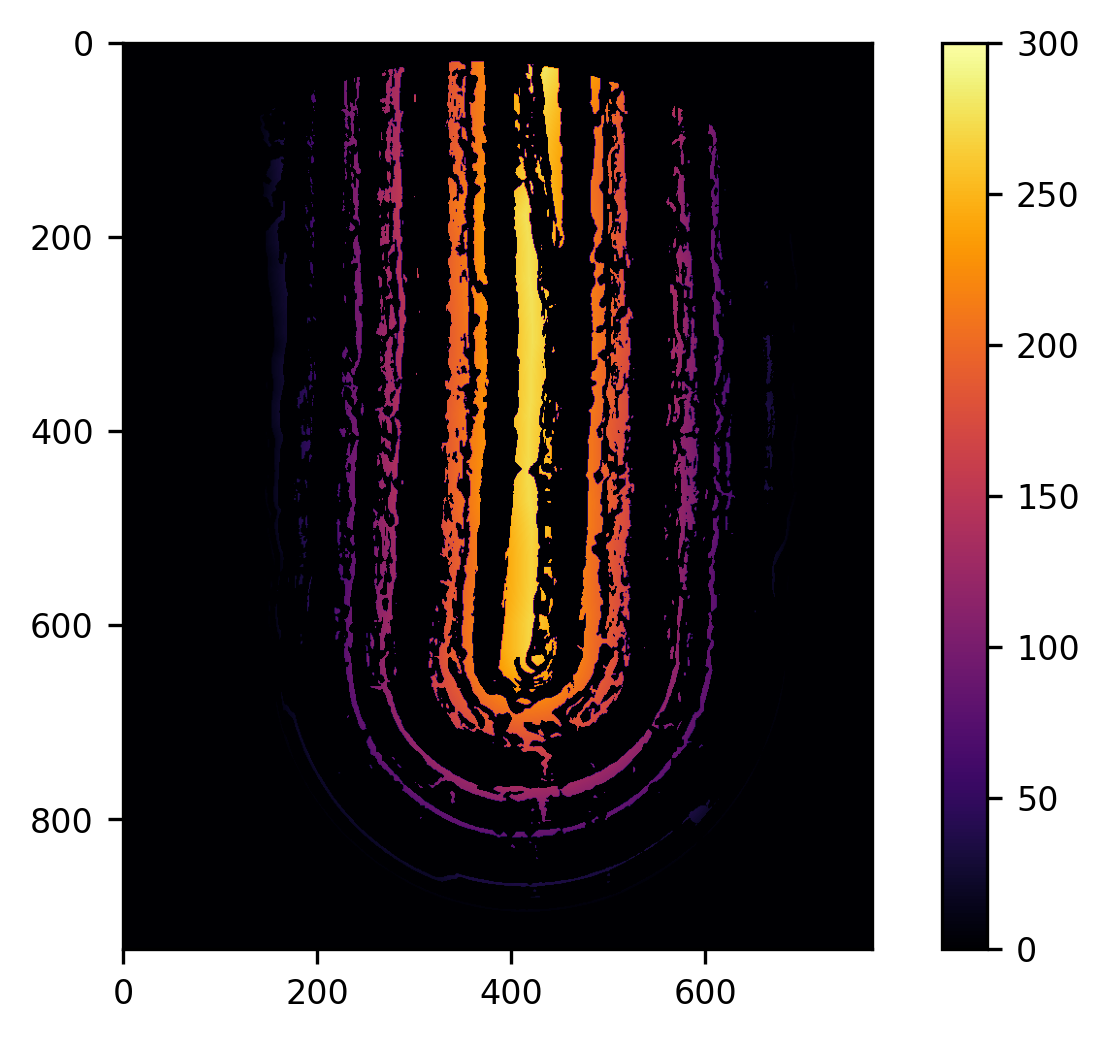

In [134]:
plt.imshow(2*dist[1500,:,:]*BW_voids[1500,:,:], cmap='inferno', vmax=600)
plt.colorbar()

## Color particles with given properties
Create scalar image of the labelled particles colored according to their volume, sphericity, or distance age. The `spam.label` toolkit is used.
- Particle sphericity:

In [ ]:
regions_sphericity = spam.label.convertLabelToFloat(regions, sphericity)

In [ ]:
# dxchange.write_tiff_stack(regions_sphericity, work_folder+"/masks/100slices_regions_sphericity/slice.tiff")

- Particle volume:

In [ ]:
regions_volume = spam.label.convertLabelToFloat(regions, volumes)

In [ ]:
# dxchange.write_tiff_stack(regions_volume, work_folder+"/masks/100slices_regions_volume/slice.tiff")

- Particle distance from corrosion front

In [ ]:
regions_pit_dist = spam.label.convertLabelToFloat(regions, distances_pit_bottom)

In [ ]:
# dxchange.write_tiff_stack(regions_pit_dist, work_folder+"/masks/100slices_regions_age/slice.tiff")

- Particle orientation in the X-Y plane - angle from X (0-90 deg.)

In [71]:
regions_orientation_XYplane = spam.label.convertLabelToFloat(regions, theta)

In [74]:
dxchange.write_tiff_stack(regions_orientation_XYplane, work_folder+"/masks/100slices_regions_orientation_XYplane/slice.tiff")

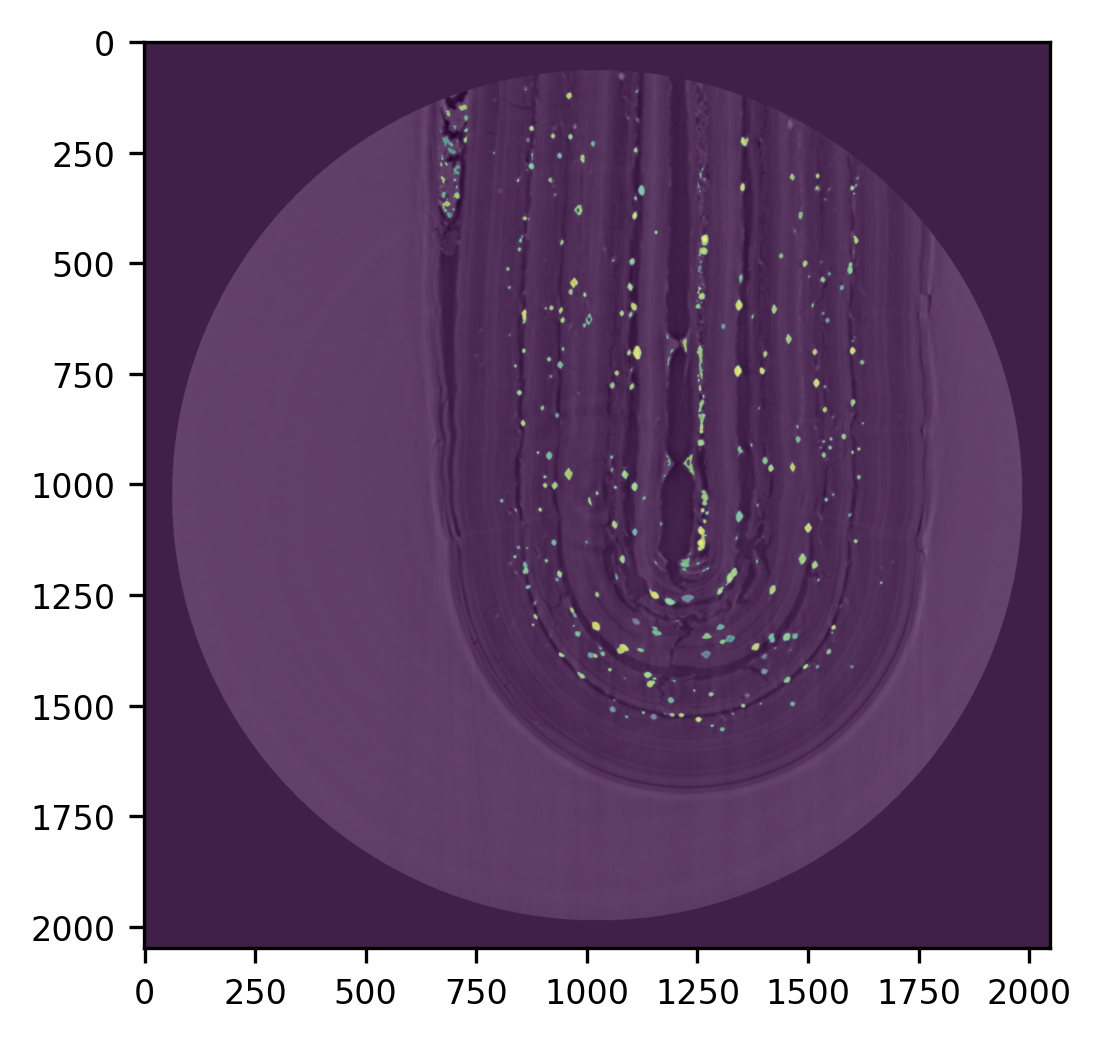

In [73]:
# Inspect slice
plt.imshow(data_3D[50,:,:], cmap='gray')
plt.imshow(regions_orientation_XYplane[50,:,:], cmap='viridis', alpha=0.5)

## Save vector filed data of particle orientation
We use `meshio` to save an `unstructured grid` `VTK` file containing the coordinates of each particle's center of mass and its orientation vector.
This file can be loaded and visualized in paraview:
<!-- ![pearls orientation](100slices_regions_orientation.png) -->
![pearls orientation](crystals_orientation_bg.png)

The coordinates [x,y,z] of the particle's center of mass are stored in the array: `centresOfMass[1:, [2, 1, 0]]`.
The particle's orientation vector [x,y,z] is in `MOIeigenVectors[1:, [8, 7, 6]]`.

In [68]:
meshio.write_points_cells(work_folder+"/crystals_orientation.vtk",
                          centresOfMass[1:, [2, 1, 0]], [],
                          point_data={"MOIeigenVector1": MOIeigenVectors[1:, [2, 1, 0]],
                                      "MOIeigenVector2": MOIeigenVectors[1:, [5, 4, 3]],
                                      "MOIeigenVector3": MOIeigenVectors[1:, [8, 7, 6]],
                                      "projection_phi": projection_theta_r[:, 0],
                                      "projection_theta": projection_theta_r[:, 1],
                                      "anisotropy": DA,
                                      "theta": theta,
                                      "sphericity": sphericity[1:].astype('float'),
                                      "volumes": pearl_volume[1:].astype('int')})

## Save results
We use `h5py` to export a HDF5 dataset of the analysis results

In [1]:
import h5py

In [67]:
MOIeigenValues.dtype

dtype('float32')

In [74]:
with h5py.File(res_folder+"/581681_punta_HR_stitch2_crystals_results_230221.hdf5", "w") as f:
    g_spam = f.create_group("spam")
    g_spam.create_dataset("volume", data=pearl_volume, dtype='uint32', compression="gzip")
    g_spam.create_dataset("sphericity", data=sphericity.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("MOIeigenValues", data=MOIeigenValues.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("MOIeigenVectors", data=MOIeigenVectors.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("DA", data=DA.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("centresOfMass", data=centresOfMass.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("projection_theta_r", data=projection_theta_r.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("theta", data=theta.astype('float16'), dtype='float16', compression="gzip")
    
    g_location = f.create_group("particle_location")
    g_location.create_dataset("dist_particle-pitfront", data=distances_pit_bottom.astype('float16'), dtype='float16', compression="gzip")
    g_location.create_dataset("dist_particle-void", data=distances_voids.astype('float16'), dtype='float16', compression="gzip")
    g_location.create_dataset("dist_void-pitfront", data=voids_dist_front.astype('float16'), dtype='float16', compression="gzip")

---
**To do:**
- [X] add DA scalar field
- [ ] display in Paraview scaling and coloring by DA
- [X] display in Paraview coloring by orientation angle with respect to X (0-90 deg)
- [ ] Generate table of the particle centroids and first eigenvector components.

---
# Dependencies

In [1]:
import watermark

In [ ]:
%load_ext watermark

%watermark
%watermark --iversions

---
# References
-  

---
# Acknowledgements
-  The authors acknowledge the [CERIC-ERIC](https://www.ceric-eric.eu/) Consortium for the access to experimental facilities and financial support